In [2]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [3]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.igtd import IGTD
from kan import *
from tqdm import tqdm


import traceback
import time
import gc
import copy
import traceback
import torch.nn as nn
import cv2
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
#from torch.optim import LBFGS


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [4]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# BEST 3.23

In [5]:
folder="data/puma8NH"
x_col=["theta1", "theta2", "theta3", "thetad1", "thetad2", "thetad3", "tau1","tau2"]
target_col=["target"]

# Functions

### Load Dataset and Images

In [6]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)
    #print(valid_rows)
    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col

    return df_X, df_y

In [7]:
def load_and_preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val, image_model, problem_type, batch_size=32):
    # Add target column to input for IGTD
    X_train_full = X_train.copy()
    X_train_full["target"] = y_train.values

    X_val_full = X_val.copy()
    X_val_full["target"] = y_val.values

    X_test_full = X_test.copy()
    X_test_full["target"] = y_test.values

    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        image_model.fit_transform(X_train_full, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}/model.pkl')
    else:
        print("The images are already generated")

    # Load image paths
    imgs_train = pd.read_csv(os.path.join(f'{images_folder}/train', f'{problem_type}.csv'))
    imgs_train["images"] = images_folder + "/train/" + imgs_train["images"]

    if not os.path.exists(f'{images_folder}/val'):
        image_model.transform(X_val_full, f'{images_folder}/val')
    else:
        print("The images are already generated")

    imgs_val = pd.read_csv(os.path.join(f'{images_folder}/val', f'{problem_type}.csv'))
    imgs_val["images"] = images_folder + "/val/" + imgs_val["images"]

    if not os.path.exists(f'{images_folder}/test'):
        image_model.transform(X_test_full, f'{images_folder}/test')
    else:
        print("The images are already generated")

    imgs_test = pd.read_csv(os.path.join(f'{images_folder}/test', f'{problem_type}.csv'))
    imgs_test["images"] = images_folder + "/test/" + imgs_test["images"]

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in imgs_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in imgs_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in imgs_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)

    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape

In [8]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

### Functions for KAN

In [9]:
def average_rmse(output, val_target):
    """
    Computes the root mean squared error (RMSE) between output and val_target.

    Args:
        output (torch.Tensor): The predicted output tensor.
        val_target (torch.Tensor): The ground truth tensor.
    
    Returns:
        float: The RMSE value.
    """
    mse = torch.mean((output - val_target) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [10]:
def custom_fit(model, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, 
               grid_update_num=10, loss_fn=None, lr=1.,start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
            metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', 
               singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
    '''
    training

    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['val_input'], dataset['val_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            entropy penalty strength
        lamb_coef : float
            coefficient magnitude penalty strength
        lamb_coefdiff : float
            difference of nearby coefficits (smoothness) penalty strength
        update_grid : bool
            If True, update grid regularly before stop_grid_update_step
        grid_update_num : int
            the number of grid updates before stop_grid_update_step
        start_grid_update_step : int
            no grid updates before this training step
        stop_grid_update_step : int
            no grid updates after this training step
        loss_fn : function
            loss function
        lr : float
            learning rate
        batch : int
            batch size, if -1 then full.
        save_fig_freq : int
            save figure every (save_fig_freq) steps
        singularity_avoiding : bool
            indicate whether to avoid singularity for the symbolic part
        y_th : float
            singularity threshold (anything above the threshold is considered singular and is softened in some ways)
        reg_metric : str
            regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
    --------
        results : dic
            results['train_loss'], 1D array of training losses (RMSE)
            results['val_loss'], 1D array of val losses (RMSE)
            results['reg'], 1D array of regularization
            other metrics specified in metrics
        best_model:
    '''

    if lamb > 0. and not model.save_act:
        print('setting lamb=0. If you want to set lamb > 0, set model.save_act=True')
        
    old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(lamb)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    if loss_fn == None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
    else:
        loss_fn = loss_fn_eval = loss_fn

    grid_update_freq = int(stop_grid_update_step / grid_update_num)

    if opt == "Adam":
        optimizer = torch.optim.Adam(model.get_params(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.get_params(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32,
                          tolerance_change=1e-32,
                          tolerance_ys=1e-32)

    results = {}
    results['train_loss'] = []
    results['val_loss'] = []
    results['reg'] = []
    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_val = dataset['val_input'].shape[0]
    else:
        batch_size = batch
        batch_size_val = batch

    global train_loss, reg_

    def closure():
        global train_loss, reg_
        optimizer.zero_grad()
        pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
        train_loss = loss_fn(pred, dataset['train_label'][train_id])
        if model.save_act:
            if reg_metric == 'edge_backward':
                model.attribute()
            if reg_metric == 'node_backward':
                model.node_attribute()
            reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
        else:
            reg_ = torch.tensor(0.)
        objective = train_loss + lamb * reg_
        objective.backward()
        return objective

    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')
    
    for epoch in pbar:
        
        if epoch == steps-1 and old_save_act:
            model.save_act = True
            
        if save_fig and epoch % save_fig_freq == 0:
            save_act = model.save_act
            model.save_act = True
        
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        val_id = np.random.choice(dataset['val_input'].shape[0], batch_size_val, replace=False)

        if epoch % grid_update_freq == 0 and epoch < stop_grid_update_step and update_grid and epoch >= start_grid_update_step:
            model.update_grid(dataset['train_input'][train_id])

        if opt == "LBFGS":
            optimizer.step(closure)

        if opt == "Adam":
            pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if model.save_act:
                if reg_metric == 'edge_backward':
                    model.attribute()
                if reg_metric == 'node_backward':
                    model.node_attribute()
                reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_ = torch.tensor(0.)
            loss = train_loss + lamb * reg_
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = loss_fn_eval(model.forward(dataset['val_input'][val_id]), dataset['val_label'][val_id])
        
        
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())

        if val_loss < best_loss:
            best_epoch = epoch
            best_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
        
        results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
        results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())
        results['reg'].append(reg_.cpu().detach().numpy())

        if epoch % log == 0:
            if display_metrics == None:
                pbar.set_description("| train_loss: %.2e | val_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(val_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
            else:
                string = ''
                data = ()
                for metric in display_metrics:
                    string += f' {metric}: %.2e |'
                    try:
                        results[metric]
                    except:
                        raise Exception(f'{metric} not recognized')
                    data += (results[metric][-1],)
                pbar.set_description(string % data)
                
        
        if save_fig and epoch % save_fig_freq == 0:
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
            plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
            plt.close()
            model.save_act = save_act

    model.log_history('fit')
    # revert back to original state
    model.symbolic_enabled = old_symbolic_enabled
    print(f"✅ Best validation loss: {best_loss:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [11]:
def grid_search_kan(dataset, output_dim=1):
    hidden_neuron_options = list(range(1, attributes // 2 + 1))
    grid_options = list(range(3, 7))
    lamb_options = [1., 0.1, 0.01, 0.001, 0.0001, 0.00001]

    top_models = []  # list of dicts: each will have 'loss', 'config', 'state_dict'

    for hidden in hidden_neuron_options:
        for grid in grid_options:
            for lamb in lamb_options:
                print(f"Testing width=[{attributes}, {hidden}, {output_dim}], lamb={lamb}, grid={grid}")
                model = KAN(width=[attributes, hidden, output_dim], grid=grid, k=3, seed=381, device=device)
                
                # Custom training
                model_state, _, best_epoch = custom_fit(model, dataset, opt="LBFGS", steps=40, lamb=lamb)
                model.load_state_dict(model_state)

                # Evaluate
                avg_loss = average_rmse(model(dataset['test_input']), dataset['test_label'])

                # Save this model info
                top_models.append({
                    "loss": avg_loss,
                    "config": {"hidden": hidden, "grid": grid, "lamb": lamb},
                    #"state_dict": copy.deepcopy(model_state),
                    "best_epoch": best_epoch
                })
                
                del model
                torch.cuda.empty_cache()
                gc.collect()

                # Keep only top 5
            top_models = sorted(top_models, key=lambda x: x["loss"])[:5]

    print("\n✅ Top 5 Configurations:")
    for i, entry in enumerate(top_models):
        cfg = entry["config"]
        print(f"{i+1}. width=[{attributes}, {cfg['hidden']}, {output_dim}], grid={cfg['grid']}, lamb={cfg['lamb']} | best_epoch={entry['best_epoch']} | loss={entry['loss']:.5f}")

    #return top_models

### Functions for CNN

In [12]:
def fit_cnn_only_model(model, dataset, steps=100, lr=1.0, loss_fn=None, batch=-1, opt="LBFGS"):
    """
    Trains a CNN-only model using LBFGS.

    Args:
        model: CNN-only PyTorch model.
        dataset: Dictionary with keys: 'train_img', 'train_label', 'val_img', 'val_label'.
        steps: Number of training iterations.
        lr: Learning rate.
        loss_fn: Loss function. Defaults to MSE.

    Returns:
        results: Dict with lists of train/val losses.
        best_model_state: Best weights based on val loss.
    """
    device = model.device
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Optimizer selection
    if opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    elif opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer '{opt}'")

    n_train = dataset["train_img"].shape[0]
    n_val = dataset["val_img"].shape[0]
    batch_size = n_train if batch == -1 or batch > n_train else batch

    results = {'train_loss': [], 'val_loss': []}
    best_model_state = None
    best_loss = float("inf")
    best_epoch = -1

    pbar = tqdm(range(steps), desc="Training CNN Only ({opt})", ncols=100)

    for step in pbar:
        train_idx = np.random.choice(n_train, batch_size, replace=False)
        #train_idx = torch.randperm(n_train)[:min(32, n_train)]  # small batch
        x_train = dataset["train_img"][train_idx].to(device)
        y_train = dataset["train_label"][train_idx].to(device)
        if opt == "LBFGS":
            def closure():
                optimizer.zero_grad()
                output = model(0, x_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                return loss
            optimizer.step(closure)
            train_loss = closure().item()

        else:  # AdamW
            optimizer.zero_grad()
            output = model(0, x_train)
            loss = loss_fn(output, y_train)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()

        with torch.no_grad():
            val_output = model(0, dataset["val_img"].to(device))
            val_loss = loss_fn(val_output, dataset["val_label"].to(device)).item()

        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = step
            best_model_state = copy.deepcopy(model.state_dict())

        pbar.set_description(f"| Train: {train_loss:.4e} | Val: {val_loss:.4e} |")

    print(f"✅ Best validation loss: {best_loss:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [13]:
def build_custom_cnn_model(cnn_blocks, dense_layers, imgs_shape, device='cuda'):
    class CustomCNNModel(nn.Module):
        def __init__(self):
            super(CustomCNNModel, self).__init__()
            self.device = device

            cnn_layers = []
            in_channels = imgs_shape[0]
            out_channels = 16
            cnn_blocks_list = [8, 6, 5]
            size_layer_norm = cnn_blocks_list[cnn_blocks-1]
            
            f_layer_size = 10 - cnn_blocks*2
            for i in range(cnn_blocks):
                cnn_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2))
                
                if i < cnn_blocks - 1:
                    cnn_layers.append(nn.BatchNorm2d(out_channels))
                    cnn_layers.append(nn.ReLU())
                    cnn_layers.append(nn.MaxPool2d(2))
                else:
                    # Last block: LayerNorm + Sigmoid + Flatten
                    cnn_layers.append(nn.LayerNorm([out_channels, size_layer_norm, size_layer_norm]))
                    cnn_layers.append(nn.Sigmoid())
                    cnn_layers.append(nn.Flatten())
                in_channels = out_channels
                out_channels *= 2

            self.cnn_branch = nn.Sequential(*cnn_layers).to(device)
            self.flat_size = self._get_flat_size(imgs_shape)

            # Dense (FC) layers
            fc_layers = []
            input_dim = self.flat_size
            for i in range(dense_layers - 1):
                fc_layers.append(nn.Linear(int(input_dim), int(input_dim // 2)))
                fc_layers.append(nn.ReLU())
                input_dim = input_dim // 2
            fc_layers.append(nn.Linear(int(input_dim), 1))

            self.fc = nn.Sequential(*fc_layers).to(device)

        def _get_flat_size(self, imgs_shape):
            dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
            x = self.cnn_branch(dummy_input)
            return x.shape[1]

        def forward(self, num_input, img_input):
            img_input = img_input.to(self.device)
            features = self.cnn_branch(img_input)
            output = self.fc(features)
            return output

    return CustomCNNModel()

In [14]:
def grid_search_cnn(dataset, steps=110, opt='LBFGS', batch=-1):
    cnn_blocks_options = list(range(1, 4))
    dense_layers_options = list(range(1, 4))

    top_models = []  # list of dicts: each will have 'loss', 'config', 'state_dict'

    for cnn_blocks in cnn_blocks_options:
        for dense_layers in dense_layers_options:
            print(f"Testing cnn_blocks={cnn_blocks}, dense_layers={dense_layers}")
            model = build_custom_cnn_model(cnn_blocks, dense_layers, imgs_shape)
            
            # Custom training
            model_state, _, best_epoch = fit_cnn_only_model(model, dataset, steps=steps, opt=opt, batch=batch)
            model.load_state_dict(model_state)

            # Evaluate
            avg_loss = average_rmse(model(0, dataset['test_img']), dataset['test_label'])

            # Save this model info
            top_models.append({
                "loss": avg_loss,
                "config": {"cnn_blocks": cnn_blocks, "dense_layers": dense_layers},
                "state_dict": copy.deepcopy(model_state),
                "best_epoch": best_epoch
            })
            
            del model
            torch.cuda.empty_cache()
            gc.collect()
            # Keep only top 5
            top_models = sorted(top_models, key=lambda x: x["loss"])[:5]

    print("\n✅ Top 5 Configurations:")
    for i, entry in enumerate(top_models):
        cfg = entry["config"]
        print(f"{i+1}. cnn_blocks={cfg['cnn_blocks']}, dense_layers={cfg['dense_layers']} | best_epoch={entry['best_epoch']} | loss={entry['loss']:.5f}")

    #return top_models

### Hybrid Functions

In [15]:
def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="AdamW", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["val_input"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif opt == "LBFGS":        
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {'train_loss': [], 'eval_loss': [], 'reg': []}
    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)
        
        cached_loss = {}
        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val_inner += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            cached_loss['loss'] = loss_val_inner.detach()
            cached_loss['reg'] = reg_val_inner.detach()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated = model.get_concat_output(mlp_batch, cnn_batch)

            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = cached_loss['loss']
            reg_val = cached_loss['reg']
        else:  # AdamW branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()


        with torch.no_grad():
            mlp_eval = dataset["val_input"][eval_indices]
            img_eval = dataset["val_img"][eval_indices]
            target_eval = dataset["val_label"][eval_indices]
            eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        if eval_loss < best_loss:
            best_epoch = step
            best_loss = eval_loss
            best_model_state = copy.deepcopy(model.state_dict())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            string = ''
            data = ()
            for metric in display_metrics:
                string += f' {metric}: %.2e |'
                try:
                    results[metric]
                except:
                    raise Exception(f'{metric} not recognized')
                data += (results[metric][-1],)
            pbar.set_description(string % data)
        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')
    print(f"✅ Best validation loss: {best_loss:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [16]:
def try_create_model(model_class, attributes, imgs_shape, kan_neurons, kan_grid):
    try:
        model = model_class(attributes, imgs_shape, kan_neurons, kan_grid)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [17]:
def grid_search_kan_hybrid(dataset, model_class, max_steps=30):
    hidden_neuron_options = list(range(1, attributes // 2 + 1))
    grid_options = list(range(3, 7))
    lamb_options = [1., 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

    top_models = []  # list of dicts: each will have 'loss', 'config', 'state_dict'

    for hidden in hidden_neuron_options:
        for grid in grid_options:
            for lamb in lamb_options:
                print(f"Testing {hidden} hidden neurons, lamb={lamb}, grid={grid}")
                model = try_create_model(model_class, attributes, imgs_shape, kan_neurons=hidden, kan_grid=grid)  # Attempt to create Model3
                
                # Custom training
                #_, model_state, _ = custom_fit(model, dataset, opt="LBFGS", steps=40, lamb=lamb)
                model_state, _, best_epoch = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=max_steps, lamb=lamb)
                model.load_state_dict(model_state)

                # Evaluate
                avg_loss = average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label'])

                # Save this model info
                top_models.append({
                    "loss": avg_loss,
                    "config": {"hidden": hidden, "grid": grid, "lamb": lamb},
                    #"state_dict": copy.deepcopy(model_state),
                    "best_epoch": best_epoch
                })
                del model
                torch.cuda.empty_cache()
                gc.collect()
        # Keep only top 5
        top_models = sorted(top_models, key=lambda x: x["loss"])[:5]

    print("\n✅ Top 5 Configurations:")
    for i, entry in enumerate(top_models):
        cfg = entry["config"]
        print(f"{i+1}. width=[{attributes}, {cfg['hidden']}, 1], grid={cfg['grid']}, lamb={cfg['lamb']}| best_epoch={entry['best_epoch']} | loss={entry['loss']:.5f}")


# Load Dataset and Images

In [18]:
X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [19]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

3


In [20]:
from TINTOlib.igtd import IGTD
dataset_name = 'puma8NH'
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem=problem_type, 
                   scale=[image_size,image_size],
                   fea_dist_method='Euclidean',
                   image_dist_method='Euclidean',
                   error='abs',
                   max_step=30000,
                   val_step=300,
                   zoom=2,
                   random_seed=SEED)

name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [21]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

Images shape:  (3, 6, 6)
Attributes:  8


In [22]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

In [23]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_input": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_label": train_target.to(device),
    "val_input": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_label": val_target.to(device),
    "test_input": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_label": test_target.to(device),
}

In [24]:
# Print the shapes of the tensors
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)

Train data shape: torch.Size([5242, 8])
Train target shape: torch.Size([5242, 1])
Test data shape: torch.Size([1639, 8])
Test target shape: torch.Size([1639, 1])
Validation data shape: torch.Size([1311, 8])
Validation target shape: torch.Size([1311, 1])


# Grid Search for KAN

In [25]:
grid_search_kan(dataset)

Testing width=[8, 1, 1], lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.69e+00 | val_loss: 5.86e+00 | reg: 1.49e-01 | : 100%|█| 40/40 [00:06<00:00,  6.26it/


saving model version 0.1
✅ Best validation loss: 3.4309e+01 at 4 epoch
Testing width=[8, 1, 1], lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e+00 | val_loss: 3.37e+00 | reg: 1.40e+01 | : 100%|█| 40/40 [00:07<00:00,  5.09it/


saving model version 0.1
✅ Best validation loss: 1.1339e+01 at 4 epoch
Testing width=[8, 1, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | val_loss: 3.39e+00 | reg: 1.44e+01 | : 100%|█| 40/40 [00:10<00:00,  3.95it/


saving model version 0.1
✅ Best validation loss: 1.1237e+01 at 3 epoch
Testing width=[8, 1, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | val_loss: 3.39e+00 | reg: 1.48e+01 | : 100%|█| 40/40 [00:11<00:00,  3.61it/


saving model version 0.1
✅ Best validation loss: 1.1252e+01 at 3 epoch
Testing width=[8, 1, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | val_loss: 3.39e+00 | reg: 1.50e+01 | : 100%|█| 40/40 [00:09<00:00,  4.19it/


saving model version 0.1
✅ Best validation loss: 1.1279e+01 at 3 epoch
Testing width=[8, 1, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | val_loss: 3.39e+00 | reg: 1.51e+01 | : 100%|█| 40/40 [00:10<00:00,  3.97it/


saving model version 0.1
✅ Best validation loss: 1.1266e+01 at 2 epoch
Testing width=[8, 1, 1], lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.60e+00 | val_loss: 5.77e+00 | reg: 1.46e-01 | : 100%|█| 40/40 [00:06<00:00,  5.90it/


saving model version 0.1
✅ Best validation loss: 3.3280e+01 at 3 epoch
Testing width=[8, 1, 1], lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e+00 | val_loss: 3.36e+00 | reg: 1.25e+01 | : 100%|█| 40/40 [00:08<00:00,  4.78it/


saving model version 0.1
✅ Best validation loss: 1.1278e+01 at 4 epoch
Testing width=[8, 1, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | val_loss: 3.38e+00 | reg: 1.41e+01 | : 100%|█| 40/40 [00:09<00:00,  4.17it/


saving model version 0.1
✅ Best validation loss: 1.1278e+01 at 4 epoch
Testing width=[8, 1, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | val_loss: 3.38e+00 | reg: 1.50e+01 | : 100%|█| 40/40 [00:09<00:00,  4.04it/


saving model version 0.1
✅ Best validation loss: 1.1257e+01 at 3 epoch
Testing width=[8, 1, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | val_loss: 3.39e+00 | reg: 1.46e+01 | : 100%|█| 40/40 [00:09<00:00,  4.08it/


saving model version 0.1
✅ Best validation loss: 1.1263e+01 at 4 epoch
Testing width=[8, 1, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | val_loss: 3.38e+00 | reg: 1.46e+01 | : 100%|█| 40/40 [00:09<00:00,  4.14it/


saving model version 0.1
✅ Best validation loss: 1.1257e+01 at 3 epoch
Testing width=[8, 1, 1], lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.69e+00 | val_loss: 5.86e+00 | reg: 1.75e-01 | : 100%|█| 40/40 [00:04<00:00,  9.09it/


saving model version 0.1
✅ Best validation loss: 3.4319e+01 at 6 epoch
Testing width=[8, 1, 1], lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | val_loss: 3.36e+00 | reg: 1.28e+01 | : 100%|█| 40/40 [00:08<00:00,  4.68it/


saving model version 0.1
✅ Best validation loss: 1.1222e+01 at 22 epoch
Testing width=[8, 1, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.36e+00 | val_loss: 3.45e+00 | reg: 1.16e+01 | : 100%|█| 40/40 [00:10<00:00,  3.98it/


saving model version 0.1
✅ Best validation loss: 1.1772e+01 at 20 epoch
Testing width=[8, 1, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.31e+00 | val_loss: 3.38e+00 | reg: 1.32e+01 | : 100%|█| 40/40 [00:09<00:00,  4.06it/


saving model version 0.1
✅ Best validation loss: 1.1311e+01 at 14 epoch
Testing width=[8, 1, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.31e+00 | val_loss: 3.38e+00 | reg: 1.39e+01 | : 100%|█| 40/40 [00:10<00:00,  3.83it/


saving model version 0.1
✅ Best validation loss: 1.1277e+01 at 9 epoch
Testing width=[8, 1, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.31e+00 | val_loss: 3.37e+00 | reg: 1.28e+01 | : 100%|█| 40/40 [00:09<00:00,  4.17it/


saving model version 0.1
✅ Best validation loss: 1.1296e+01 at 36 epoch
Testing width=[8, 1, 1], lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.67e+00 | val_loss: 5.84e+00 | reg: 4.49e-02 | : 100%|█| 40/40 [00:04<00:00,  9.76it/


saving model version 0.1
✅ Best validation loss: 3.4076e+01 at 3 epoch
Testing width=[8, 1, 1], lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e+00 | val_loss: 3.36e+00 | reg: 1.22e+01 | : 100%|█| 40/40 [00:09<00:00,  4.37it/


saving model version 0.1
✅ Best validation loss: 1.1266e+01 at 35 epoch
Testing width=[8, 1, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.31e+00 | val_loss: 3.37e+00 | reg: 1.48e+01 | : 100%|█| 40/40 [00:09<00:00,  4.07it/


saving model version 0.1
✅ Best validation loss: 1.1344e+01 at 39 epoch
Testing width=[8, 1, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.30e+00 | val_loss: 3.38e+00 | reg: 1.27e+01 | : 100%|█| 40/40 [00:09<00:00,  4.20it/


saving model version 0.1
✅ Best validation loss: 1.1267e+01 at 6 epoch
Testing width=[8, 1, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | val_loss: 3.41e+00 | reg: 1.18e+01 | : 100%|█| 40/40 [00:09<00:00,  4.22it/


saving model version 0.1
✅ Best validation loss: 1.1626e+01 at 37 epoch
Testing width=[8, 1, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | val_loss: 3.42e+00 | reg: 1.25e+01 | : 100%|█| 40/40 [00:09<00:00,  4.16it/


saving model version 0.1
✅ Best validation loss: 1.1494e+01 at 7 epoch
Testing width=[8, 2, 1], lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.67e+00 | val_loss: 5.84e+00 | reg: 1.56e-01 | : 100%|█| 40/40 [00:07<00:00,  5.19it/


saving model version 0.1
✅ Best validation loss: 3.4134e+01 at 4 epoch
Testing width=[8, 2, 1], lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.12e+00 | val_loss: 3.11e+00 | reg: 1.82e+01 | : 100%|█| 40/40 [00:10<00:00,  3.77it/


saving model version 0.1
✅ Best validation loss: 9.6585e+00 at 24 epoch
Testing width=[8, 2, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.07e+00 | val_loss: 3.12e+00 | reg: 2.58e+01 | : 100%|█| 40/40 [00:11<00:00,  3.63it/


saving model version 0.1
✅ Best validation loss: 9.6125e+00 at 24 epoch
Testing width=[8, 2, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.08e+00 | val_loss: 3.12e+00 | reg: 3.35e+01 | : 100%|█| 40/40 [00:13<00:00,  2.99it/


saving model version 0.1
✅ Best validation loss: 9.6415e+00 at 21 epoch
Testing width=[8, 2, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.08e+00 | val_loss: 3.11e+00 | reg: 4.14e+01 | : 100%|█| 40/40 [00:13<00:00,  3.04it/


saving model version 0.1
✅ Best validation loss: 9.6392e+00 at 10 epoch
Testing width=[8, 2, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.08e+00 | val_loss: 3.11e+00 | reg: 3.51e+01 | : 100%|█| 40/40 [00:11<00:00,  3.43it/


saving model version 0.1
✅ Best validation loss: 9.6183e+00 at 13 epoch
Testing width=[8, 2, 1], lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.67e+00 | val_loss: 5.83e+00 | reg: 1.49e-01 | : 100%|█| 40/40 [00:09<00:00,  4.31it/


saving model version 0.1
✅ Best validation loss: 3.4033e+01 at 14 epoch
Testing width=[8, 2, 1], lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e+00 | val_loss: 3.37e+00 | reg: 1.22e+01 | : 100%|█| 40/40 [00:11<00:00,  3.57it/


saving model version 0.1
✅ Best validation loss: 1.1325e+01 at 38 epoch
Testing width=[8, 2, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.06e+00 | val_loss: 3.13e+00 | reg: 2.22e+01 | : 100%|█| 40/40 [00:12<00:00,  3.27it/


saving model version 0.1
✅ Best validation loss: 9.5916e+00 at 4 epoch
Testing width=[8, 2, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.09e+00 | val_loss: 3.11e+00 | reg: 2.97e+01 | : 100%|█| 40/40 [00:12<00:00,  3.27it/


saving model version 0.1
✅ Best validation loss: 9.6718e+00 at 29 epoch
Testing width=[8, 2, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.10e+00 | val_loss: 3.13e+00 | reg: 4.18e+01 | : 100%|█| 40/40 [00:11<00:00,  3.39it/


saving model version 0.1
✅ Best validation loss: 9.7791e+00 at 38 epoch
Testing width=[8, 2, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.09e+00 | val_loss: 3.12e+00 | reg: 3.06e+01 | : 100%|█| 40/40 [00:12<00:00,  3.19it/


saving model version 0.1
✅ Best validation loss: 9.6485e+00 at 32 epoch
Testing width=[8, 2, 1], lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.68e+00 | val_loss: 5.85e+00 | reg: 2.05e-01 | : 100%|█| 40/40 [00:07<00:00,  5.55it/


saving model version 0.1
✅ Best validation loss: 3.4252e+01 at 15 epoch
Testing width=[8, 2, 1], lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.13e+00 | val_loss: 3.18e+00 | reg: 2.15e+01 | : 100%|█| 40/40 [00:12<00:00,  3.25it/


saving model version 0.1
✅ Best validation loss: 1.0050e+01 at 35 epoch
Testing width=[8, 2, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.10e+00 | val_loss: 3.15e+00 | reg: 2.39e+01 | : 100%|█| 40/40 [00:12<00:00,  3.14it/


saving model version 0.1
✅ Best validation loss: 9.9373e+00 at 38 epoch
Testing width=[8, 2, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.10e+00 | val_loss: 3.12e+00 | reg: 3.00e+01 | : 100%|█| 40/40 [00:11<00:00,  3.62it/


saving model version 0.1
✅ Best validation loss: 9.7493e+00 at 27 epoch
Testing width=[8, 2, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.08e+00 | val_loss: 3.13e+00 | reg: 2.71e+01 | : 100%|█| 40/40 [00:11<00:00,  3.57it/


saving model version 0.1
✅ Best validation loss: 9.8024e+00 at 17 epoch
Testing width=[8, 2, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.11e+00 | val_loss: 3.14e+00 | reg: 3.15e+01 | : 100%|█| 40/40 [00:11<00:00,  3.60it/


saving model version 0.1
✅ Best validation loss: 9.8359e+00 at 39 epoch
Testing width=[8, 2, 1], lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.68e+00 | val_loss: 5.85e+00 | reg: 2.01e-01 | : 100%|█| 40/40 [00:05<00:00,  6.79it/


saving model version 0.1
✅ Best validation loss: 3.4231e+01 at 4 epoch
Testing width=[8, 2, 1], lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.11e+00 | val_loss: 3.12e+00 | reg: 1.79e+01 | : 100%|█| 40/40 [00:11<00:00,  3.58it/


saving model version 0.1
✅ Best validation loss: 9.7360e+00 at 34 epoch
Testing width=[8, 2, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.07e+00 | val_loss: 3.12e+00 | reg: 2.06e+01 | : 100%|█| 40/40 [00:11<00:00,  3.50it/


saving model version 0.1
✅ Best validation loss: 9.6989e+00 at 30 epoch
Testing width=[8, 2, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.07e+00 | val_loss: 3.12e+00 | reg: 2.36e+01 | : 100%|█| 40/40 [00:11<00:00,  3.52it/


saving model version 0.1
✅ Best validation loss: 9.6699e+00 at 21 epoch
Testing width=[8, 2, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.07e+00 | val_loss: 3.12e+00 | reg: 2.64e+01 | : 100%|█| 40/40 [00:11<00:00,  3.58it/


saving model version 0.1
✅ Best validation loss: 9.6560e+00 at 22 epoch
Testing width=[8, 2, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.07e+00 | val_loss: 3.11e+00 | reg: 2.95e+01 | : 100%|█| 40/40 [00:11<00:00,  3.59it/


saving model version 0.1
✅ Best validation loss: 9.6382e+00 at 24 epoch
Testing width=[8, 3, 1], lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.63e+00 | val_loss: 5.80e+00 | reg: 2.05e-01 | : 100%|█| 40/40 [00:06<00:00,  5.76it/


saving model version 0.1
✅ Best validation loss: 3.3662e+01 at 4 epoch
Testing width=[8, 3, 1], lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.11e+00 | val_loss: 3.11e+00 | reg: 1.67e+01 | : 100%|█| 40/40 [00:08<00:00,  4.90it/


saving model version 0.1
✅ Best validation loss: 9.6442e+00 at 13 epoch
Testing width=[8, 3, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.05e+00 | val_loss: 3.14e+00 | reg: 2.66e+01 | : 100%|█| 40/40 [00:11<00:00,  3.48it/


saving model version 0.1
✅ Best validation loss: 9.7092e+00 at 12 epoch
Testing width=[8, 3, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.05e+00 | val_loss: 3.14e+00 | reg: 3.39e+01 | : 100%|█| 40/40 [00:11<00:00,  3.59it/


saving model version 0.1
✅ Best validation loss: 9.7047e+00 at 11 epoch
Testing width=[8, 3, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.09e+00 | val_loss: 3.11e+00 | reg: 4.37e+01 | : 100%|█| 40/40 [00:11<00:00,  3.63it/


saving model version 0.1
✅ Best validation loss: 9.6842e+00 at 38 epoch
Testing width=[8, 3, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.08e+00 | val_loss: 3.14e+00 | reg: 5.31e+01 | : 100%|█| 40/40 [00:10<00:00,  3.69it/


saving model version 0.1
✅ Best validation loss: 9.7264e+00 at 15 epoch
Testing width=[8, 3, 1], lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.61e+00 | val_loss: 5.78e+00 | reg: 2.79e-01 | : 100%|█| 40/40 [00:07<00:00,  5.21it/


saving model version 0.1
✅ Best validation loss: 3.3402e+01 at 4 epoch
Testing width=[8, 3, 1], lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e+00 | val_loss: 3.37e+00 | reg: 1.16e+01 | : 100%|█| 40/40 [00:10<00:00,  3.72it/


saving model version 0.1
✅ Best validation loss: 1.1216e+01 at 4 epoch
Testing width=[8, 3, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.07e+00 | val_loss: 3.11e+00 | reg: 2.07e+01 | : 100%|█| 40/40 [00:11<00:00,  3.61it/


saving model version 0.1
✅ Best validation loss: 9.6158e+00 at 11 epoch
Testing width=[8, 3, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.02e+00 | val_loss: 3.12e+00 | reg: 2.90e+01 | : 100%|█| 40/40 [00:11<00:00,  3.56it/


saving model version 0.1
✅ Best validation loss: 9.6689e+00 at 7 epoch
Testing width=[8, 3, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.04e+00 | val_loss: 3.15e+00 | reg: 2.82e+01 | : 100%|█| 40/40 [00:11<00:00,  3.58it/


saving model version 0.1
✅ Best validation loss: 9.6600e+00 at 6 epoch
Testing width=[8, 3, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.03e+00 | val_loss: 3.15e+00 | reg: 2.87e+01 | : 100%|█| 40/40 [00:11<00:00,  3.46it/


saving model version 0.1
✅ Best validation loss: 9.6565e+00 at 5 epoch
Testing width=[8, 3, 1], lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.68e+00 | val_loss: 5.85e+00 | reg: 1.52e-01 | : 100%|█| 40/40 [00:07<00:00,  5.23it/


saving model version 0.1
✅ Best validation loss: 3.4184e+01 at 4 epoch
Testing width=[8, 3, 1], lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.09e+00 | val_loss: 3.11e+00 | reg: 1.69e+01 | : 100%|█| 40/40 [00:13<00:00,  3.01it/


saving model version 0.1
✅ Best validation loss: 9.6355e+00 at 36 epoch
Testing width=[8, 3, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.08e+00 | val_loss: 3.10e+00 | reg: 2.08e+01 | : 100%|█| 40/40 [00:12<00:00,  3.23it/


saving model version 0.1
✅ Best validation loss: 9.6095e+00 at 39 epoch
Testing width=[8, 3, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.02e+00 | val_loss: 3.28e+00 | reg: 3.79e+01 | : 100%|█| 40/40 [00:10<00:00,  3.66it/


saving model version 0.1
✅ Best validation loss: 9.8333e+00 at 10 epoch
Testing width=[8, 3, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.07e+00 | val_loss: 3.11e+00 | reg: 4.57e+01 | : 100%|█| 40/40 [00:11<00:00,  3.34it/


saving model version 0.1
✅ Best validation loss: 9.5722e+00 at 19 epoch
Testing width=[8, 3, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.05e+00 | val_loss: 3.15e+00 | reg: 3.46e+01 | : 100%|█| 40/40 [00:11<00:00,  3.49it/


saving model version 0.1
✅ Best validation loss: 9.6479e+00 at 16 epoch
Testing width=[8, 3, 1], lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.67e+00 | val_loss: 5.84e+00 | reg: 1.72e-01 | : 100%|█| 40/40 [00:08<00:00,  4.70it/


saving model version 0.1
✅ Best validation loss: 3.4121e+01 at 11 epoch
Testing width=[8, 3, 1], lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.20e+00 | val_loss: 3.28e+00 | reg: 1.92e+01 | : 100%|█| 40/40 [00:11<00:00,  3.50it/


saving model version 0.1
✅ Best validation loss: 1.0717e+01 at 13 epoch
Testing width=[8, 3, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.02e+00 | val_loss: 3.18e+00 | reg: 2.81e+01 | : 100%|█| 40/40 [00:11<00:00,  3.45it/


saving model version 0.1
✅ Best validation loss: 9.7295e+00 at 8 epoch
Testing width=[8, 3, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.98e+00 | val_loss: 3.22e+00 | reg: 3.42e+01 | : 100%|█| 40/40 [00:11<00:00,  3.47it/


saving model version 0.1
✅ Best validation loss: 9.6744e+00 at 6 epoch
Testing width=[8, 3, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.00e+00 | val_loss: 3.20e+00 | reg: 3.20e+01 | : 100%|█| 40/40 [00:11<00:00,  3.47it/


saving model version 0.1
✅ Best validation loss: 9.6254e+00 at 6 epoch
Testing width=[8, 3, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.00e+00 | val_loss: 3.22e+00 | reg: 4.51e+01 | : 100%|█| 40/40 [00:11<00:00,  3.44it/


saving model version 0.1
✅ Best validation loss: 9.7794e+00 at 7 epoch
Testing width=[8, 4, 1], lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.61e+00 | val_loss: 5.78e+00 | reg: 2.02e-01 | : 100%|█| 40/40 [00:10<00:00,  3.98it/


saving model version 0.1
✅ Best validation loss: 3.3422e+01 at 4 epoch
Testing width=[8, 4, 1], lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.10e+00 | val_loss: 3.16e+00 | reg: 1.86e+01 | : 100%|█| 40/40 [00:10<00:00,  3.70it/


saving model version 0.1
✅ Best validation loss: 9.9513e+00 at 31 epoch
Testing width=[8, 4, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.03e+00 | val_loss: 3.16e+00 | reg: 3.02e+01 | : 100%|█| 40/40 [00:12<00:00,  3.33it/


saving model version 0.1
✅ Best validation loss: 9.7006e+00 at 9 epoch
Testing width=[8, 4, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.04e+00 | val_loss: 3.16e+00 | reg: 4.26e+01 | : 100%|█| 40/40 [00:11<00:00,  3.40it/


saving model version 0.1
✅ Best validation loss: 9.6931e+00 at 9 epoch
Testing width=[8, 4, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.06e+00 | val_loss: 3.14e+00 | reg: 4.30e+01 | : 100%|█| 40/40 [00:12<00:00,  3.22it/


saving model version 0.1
✅ Best validation loss: 9.7344e+00 at 13 epoch
Testing width=[8, 4, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.05e+00 | val_loss: 3.15e+00 | reg: 3.88e+01 | : 100%|█| 40/40 [00:11<00:00,  3.34it/


saving model version 0.1
✅ Best validation loss: 9.7634e+00 at 10 epoch
Testing width=[8, 4, 1], lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.62e+00 | val_loss: 5.79e+00 | reg: 2.95e-01 | : 100%|█| 40/40 [00:09<00:00,  4.13it/


saving model version 0.1
✅ Best validation loss: 3.3468e+01 at 5 epoch
Testing width=[8, 4, 1], lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e+00 | val_loss: 3.37e+00 | reg: 1.18e+01 | : 100%|█| 40/40 [00:11<00:00,  3.55it/


saving model version 0.1
✅ Best validation loss: 1.1258e+01 at 3 epoch
Testing width=[8, 4, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.02e+00 | val_loss: 3.18e+00 | reg: 3.44e+01 | : 100%|█| 40/40 [00:11<00:00,  3.61it/


saving model version 0.1
✅ Best validation loss: 9.6314e+00 at 12 epoch
Testing width=[8, 4, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.05e+00 | val_loss: 3.13e+00 | reg: 5.82e+01 | : 100%|█| 40/40 [00:11<00:00,  3.45it/


saving model version 0.1
✅ Best validation loss: 9.6258e+00 at 5 epoch
Testing width=[8, 4, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.05e+00 | val_loss: 3.13e+00 | reg: 6.36e+01 | : 100%|█| 40/40 [00:12<00:00,  3.22it/


saving model version 0.1
✅ Best validation loss: 9.6562e+00 at 5 epoch
Testing width=[8, 4, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.05e+00 | val_loss: 3.12e+00 | reg: 6.19e+01 | : 100%|█| 40/40 [00:11<00:00,  3.56it/


saving model version 0.1
✅ Best validation loss: 9.6127e+00 at 5 epoch
Testing width=[8, 4, 1], lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.68e+00 | val_loss: 5.85e+00 | reg: 1.55e-01 | : 100%|█| 40/40 [00:09<00:00,  4.08it/


saving model version 0.1
✅ Best validation loss: 3.4176e+01 at 39 epoch
Testing width=[8, 4, 1], lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.08e+00 | val_loss: 3.12e+00 | reg: 1.68e+01 | : 100%|█| 40/40 [00:11<00:00,  3.60it/


saving model version 0.1
✅ Best validation loss: 9.6777e+00 at 16 epoch
Testing width=[8, 4, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.99e+00 | val_loss: 3.21e+00 | reg: 3.48e+01 | : 100%|█| 40/40 [00:11<00:00,  3.60it/


saving model version 0.1
✅ Best validation loss: 9.8866e+00 at 9 epoch
Testing width=[8, 4, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.98e+00 | val_loss: 3.18e+00 | reg: 4.53e+01 | : 100%|█| 40/40 [00:10<00:00,  3.74it/


saving model version 0.1
✅ Best validation loss: 9.6310e+00 at 7 epoch
Testing width=[8, 4, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.99e+00 | val_loss: 3.22e+00 | reg: 4.87e+01 | : 100%|█| 40/40 [00:11<00:00,  3.57it/


saving model version 0.1
✅ Best validation loss: 9.6675e+00 at 7 epoch
Testing width=[8, 4, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.00e+00 | val_loss: 3.23e+00 | reg: 4.83e+01 | : 100%|█| 40/40 [00:11<00:00,  3.53it/


saving model version 0.1
✅ Best validation loss: 9.7726e+00 at 10 epoch
Testing width=[8, 4, 1], lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.68e+00 | val_loss: 5.85e+00 | reg: 1.61e-01 | : 100%|█| 40/40 [00:08<00:00,  4.65it/


saving model version 0.1
✅ Best validation loss: 3.4170e+01 at 4 epoch
Testing width=[8, 4, 1], lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.10e+00 | val_loss: 3.16e+00 | reg: 1.93e+01 | : 100%|█| 40/40 [00:11<00:00,  3.44it/


saving model version 0.1
✅ Best validation loss: 9.9299e+00 at 9 epoch
Testing width=[8, 4, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.98e+00 | val_loss: 3.19e+00 | reg: 3.52e+01 | : 100%|█| 40/40 [00:13<00:00,  3.02it/


saving model version 0.1
✅ Best validation loss: 9.7084e+00 at 4 epoch
Testing width=[8, 4, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.98e+00 | val_loss: 3.23e+00 | reg: 4.59e+01 | : 100%|█| 40/40 [00:13<00:00,  2.96it/


saving model version 0.1
✅ Best validation loss: 9.7526e+00 at 2 epoch
Testing width=[8, 4, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.99e+00 | val_loss: 3.30e+00 | reg: 5.33e+01 | : 100%|█| 40/40 [00:12<00:00,  3.25it/


saving model version 0.1
✅ Best validation loss: 9.7299e+00 at 3 epoch
Testing width=[8, 4, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.00e+00 | val_loss: 3.28e+00 | reg: 5.17e+01 | : 100%|█| 40/40 [00:11<00:00,  3.39it/

saving model version 0.1
✅ Best validation loss: 9.7367e+00 at 5 epoch

✅ Top 5 Configurations:
1. width=[8, 2, 1], grid=4, lamb=1e-05 | best_epoch=32 | loss=3.22794
2. width=[8, 3, 1], grid=5, lamb=0.0001 | best_epoch=19 | loss=3.23315
3. width=[8, 2, 1], grid=5, lamb=1e-05 | best_epoch=39 | loss=3.23450
4. width=[8, 2, 1], grid=5, lamb=0.001 | best_epoch=27 | loss=3.23477
5. width=[8, 3, 1], grid=3, lamb=0.001 | best_epoch=11 | loss=3.23616


# ✅ Top 5 Configurations:
1. width=[8, 2, 1], grid=4, lamb=1e-05 | best_epoch=32 | loss=3.22794
2. width=[8, 3, 1], grid=5, lamb=0.01 | best_epoch=9 | loss=3.22944
3. width=[8, 2, 1], grid=5, lamb=1e-05 | best_epoch=39 | loss=3.23450
4. width=[8, 2, 1], grid=5, lamb=0.001 | best_epoch=27 | loss=3.23477
5. width=[8, 2, 1], grid=4, lamb=0.0001 | best_epoch=24 | loss=3.2354693413

# Grid Search for CNN

In [24]:
grid_search_cnn(dataset)

Testing cnn_blocks=1, dense_layers=1


| Train: 9.0795e+00 | Val: 1.0066e+01 |: 100%|████████████████████| 110/110 [00:41<00:00,  2.68it/s]


✅ Best validation loss: 9.5251e+00 at 18 epoch
Testing cnn_blocks=1, dense_layers=2


| Train: 9.1101e+00 | Val: 9.9477e+00 |: 100%|████████████████████| 110/110 [00:46<00:00,  2.36it/s]


✅ Best validation loss: 9.6229e+00 at 25 epoch
Testing cnn_blocks=1, dense_layers=3


| Train: 9.5968e+00 | Val: 9.7768e+00 |: 100%|████████████████████| 110/110 [00:49<00:00,  2.22it/s]


✅ Best validation loss: 9.7477e+00 at 59 epoch
Testing cnn_blocks=2, dense_layers=1


| Train: 5.0665e+00 | Val: 1.5953e+01 |: 100%|████████████████████| 110/110 [00:40<00:00,  2.75it/s]


✅ Best validation loss: 9.8111e+00 at 5 epoch
Testing cnn_blocks=2, dense_layers=2


| Train: 4.8415e+00 | Val: 1.4919e+01 |: 100%|████████████████████| 110/110 [00:54<00:00,  2.01it/s]


✅ Best validation loss: 9.7545e+00 at 14 epoch
Testing cnn_blocks=2, dense_layers=3


| Train: 9.6259e+00 | Val: 1.0038e+01 |: 100%|████████████████████| 110/110 [00:27<00:00,  4.07it/s]


✅ Best validation loss: 9.9950e+00 at 18 epoch
Testing cnn_blocks=3, dense_layers=1


| Train: 3.3681e+00 | Val: 1.5214e+01 |: 100%|████████████████████| 110/110 [00:43<00:00,  2.52it/s]


✅ Best validation loss: 9.6191e+00 at 4 epoch
Testing cnn_blocks=3, dense_layers=2


| Train: 2.1833e+00 | Val: 1.8482e+01 |: 100%|████████████████████| 110/110 [01:07<00:00,  1.62it/s]


✅ Best validation loss: 9.7301e+00 at 4 epoch
Testing cnn_blocks=3, dense_layers=3


| Train: 1.0448e+01 | Val: 1.0620e+01 |: 100%|████████████████████| 110/110 [00:33<00:00,  3.27it/s]

✅ Best validation loss: 1.0616e+01 at 10 epoch

✅ Top 5 Configurations:
1. cnn_blocks=1, dense_layers=1 | best_epoch=18 | loss=3.22069
2. cnn_blocks=3, dense_layers=2 | best_epoch=4 | loss=3.24624
3. cnn_blocks=2, dense_layers=1 | best_epoch=5 | loss=3.26268
4. cnn_blocks=1, dense_layers=2 | best_epoch=25 | loss=3.26525
5. cnn_blocks=2, dense_layers=2 | best_epoch=14 | loss=3.27850


In [25]:
grid_search_cnn(dataset)

Testing cnn_blocks=1, dense_layers=1


| Train: 8.9012e+00 | Val: 1.0304e+01 |: 100%|████████████████████| 110/110 [00:41<00:00,  2.63it/s]


✅ Best validation loss: 9.5108e+00 at 18 epoch
Testing cnn_blocks=1, dense_layers=2


| Train: 9.0829e+00 | Val: 9.9281e+00 |: 100%|████████████████████| 110/110 [00:46<00:00,  2.35it/s]


✅ Best validation loss: 9.6624e+00 at 26 epoch
Testing cnn_blocks=1, dense_layers=3


| Train: 9.8750e+00 | Val: 9.7805e+00 |: 100%|████████████████████| 110/110 [00:38<00:00,  2.88it/s]


✅ Best validation loss: 9.7607e+00 at 78 epoch
Testing cnn_blocks=2, dense_layers=1


| Train: 7.7997e+00 | Val: 1.1511e+01 |: 100%|████████████████████| 110/110 [00:26<00:00,  4.18it/s]


✅ Best validation loss: 9.7255e+00 at 7 epoch
Testing cnn_blocks=2, dense_layers=2


| Train: 5.2842e+00 | Val: 1.4116e+01 |: 100%|████████████████████| 110/110 [00:52<00:00,  2.10it/s]


✅ Best validation loss: 9.8174e+00 at 8 epoch
Testing cnn_blocks=2, dense_layers=3


| Train: 9.4683e+00 | Val: 9.7571e+00 |: 100%|████████████████████| 110/110 [00:40<00:00,  2.69it/s]


✅ Best validation loss: 9.7571e+00 at 81 epoch
Testing cnn_blocks=3, dense_layers=1


| Train: 4.1550e+00 | Val: 1.4427e+01 |: 100%|████████████████████| 110/110 [00:36<00:00,  2.99it/s]


✅ Best validation loss: 9.5568e+00 at 4 epoch
Testing cnn_blocks=3, dense_layers=2


| Train: 4.5311e+00 | Val: 1.4665e+01 |: 100%|████████████████████| 110/110 [00:45<00:00,  2.43it/s]


✅ Best validation loss: 9.7126e+00 at 3 epoch
Testing cnn_blocks=3, dense_layers=3


| Train: 1.0363e+01 | Val: 1.0629e+01 |: 100%|████████████████████| 110/110 [00:36<00:00,  3.01it/s]

✅ Best validation loss: 1.0629e+01 at 15 epoch

✅ Top 5 Configurations:
1. cnn_blocks=1, dense_layers=1 | best_epoch=18 | loss=3.23118
2. cnn_blocks=2, dense_layers=1 | best_epoch=7 | loss=3.25628
3. cnn_blocks=3, dense_layers=2 | best_epoch=3 | loss=3.25922
4. cnn_blocks=2, dense_layers=2 | best_epoch=8 | loss=3.26547
5. cnn_blocks=1, dense_layers=2 | best_epoch=26 | loss=3.26898


| Train: 8.9071e+00 | Val: 1.0258e+01 |: 100%|████████████████████| 100/100 [00:37<00:00,  2.69it/s]


✅ Best validation loss: 9.5139e+00 at 11 epoch
3.2288973331451416


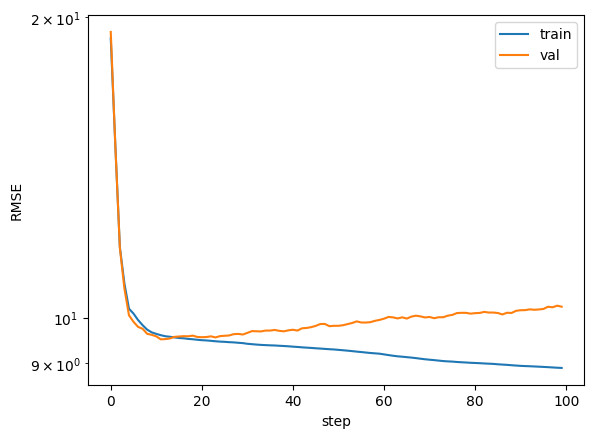

In [26]:
model0 = build_custom_cnn_model(cnn_blocks=1, dense_layers=1, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model0, dataset, steps=100)
model0.load_state_dict(model_state)
print(average_rmse(model0(0, dataset['test_img']), dataset['test_label']))
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

| Train: 4.1669e+00 | Val: 1.6786e+01 |: 100%|████████████████████| 100/100 [00:45<00:00,  2.22it/s]


✅ Best validation loss: 9.8080e+00 at 6 epoch
3.274373769760132


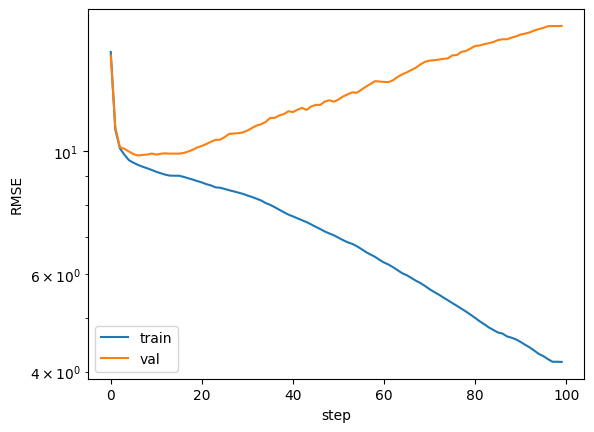

In [27]:
model0 = build_custom_cnn_model(cnn_blocks=2, dense_layers=1, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model0, dataset, steps=100)
model0.load_state_dict(model_state)
print(average_rmse(model0(0, dataset['test_img']), dataset['test_label']))
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [28]:
grid_search_cnn(dataset, steps=500, opt='AdamW', batch=-1)

Testing cnn_blocks=1, dense_layers=1


| Train: 1.4262e+01 | Val: 1.4149e+01 |: 100%|███████████████████| 500/500 [00:04<00:00, 109.19it/s]


✅ Best validation loss: 1.4047e+01 at 497 epoch
Testing cnn_blocks=1, dense_layers=2


| Train: 3.1326e+01 | Val: 3.3223e+01 |: 100%|████████████████████| 500/500 [00:05<00:00, 98.82it/s]


✅ Best validation loss: 2.5876e+01 at 250 epoch
Testing cnn_blocks=1, dense_layers=3


| Train: 3.1960e+01 | Val: 3.3896e+01 |: 100%|████████████████████| 500/500 [00:05<00:00, 85.17it/s]


✅ Best validation loss: 2.7850e+01 at 268 epoch
Testing cnn_blocks=2, dense_layers=1


| Train: 1.5790e+01 | Val: 1.6312e+01 |: 100%|████████████████████| 500/500 [00:06<00:00, 75.99it/s]


✅ Best validation loss: 1.0999e+01 at 411 epoch
Testing cnn_blocks=2, dense_layers=2


| Train: 3.1314e+01 | Val: 3.3210e+01 |: 100%|████████████████████| 500/500 [00:07<00:00, 65.75it/s]


✅ Best validation loss: 2.4560e+01 at 233 epoch
Testing cnn_blocks=2, dense_layers=3


| Train: 3.1954e+01 | Val: 3.3889e+01 |: 100%|████████████████████| 500/500 [00:08<00:00, 59.01it/s]


✅ Best validation loss: 3.1533e+01 at 315 epoch
Testing cnn_blocks=3, dense_layers=1


| Train: 6.2971e+01 | Val: 8.9880e+01 |: 100%|████████████████████| 500/500 [00:09<00:00, 50.10it/s]


✅ Best validation loss: 9.8218e+00 at 172 epoch
Testing cnn_blocks=3, dense_layers=2


| Train: 3.1362e+01 | Val: 3.3259e+01 |: 100%|████████████████████| 500/500 [00:13<00:00, 37.04it/s]


✅ Best validation loss: 2.6586e+01 at 148 epoch
Testing cnn_blocks=3, dense_layers=3


| Train: 3.2094e+01 | Val: 3.4033e+01 |: 100%|████████████████████| 500/500 [00:15<00:00, 32.65it/s]

✅ Best validation loss: 3.3259e+01 at 375 epoch

✅ Top 5 Configurations:
1. cnn_blocks=3, dense_layers=1 | best_epoch=172 | loss=3.29445
2. cnn_blocks=2, dense_layers=1 | best_epoch=411 | loss=3.45671
3. cnn_blocks=1, dense_layers=1 | best_epoch=497 | loss=3.79079
4. cnn_blocks=2, dense_layers=2 | best_epoch=233 | loss=4.84109
5. cnn_blocks=1, dense_layers=2 | best_epoch=250 | loss=4.94514


In [29]:
grid_search_cnn(dataset, steps=500, opt='AdamW', batch=32)

Testing cnn_blocks=1, dense_layers=1


| Train: 2.1836e+01 | Val: 2.4328e+01 |: 100%|███████████████████| 500/500 [00:04<00:00, 108.44it/s]


✅ Best validation loss: 1.7310e+01 at 473 epoch
Testing cnn_blocks=1, dense_layers=2


| Train: 2.8457e+01 | Val: 3.3241e+01 |: 100%|████████████████████| 500/500 [00:06<00:00, 82.17it/s]


✅ Best validation loss: 2.1370e+01 at 191 epoch
Testing cnn_blocks=1, dense_layers=3


| Train: 4.3748e+01 | Val: 3.4104e+01 |: 100%|████████████████████| 500/500 [00:06<00:00, 74.09it/s]


✅ Best validation loss: 3.2078e+01 at 295 epoch
Testing cnn_blocks=2, dense_layers=1


| Train: 2.9499e+01 | Val: 1.5040e+01 |: 100%|████████████████████| 500/500 [00:07<00:00, 70.52it/s]


✅ Best validation loss: 1.2557e+01 at 487 epoch
Testing cnn_blocks=2, dense_layers=2


| Train: 2.9233e+01 | Val: 3.3238e+01 |: 100%|████████████████████| 500/500 [00:07<00:00, 64.91it/s]


✅ Best validation loss: 2.9199e+01 at 274 epoch
Testing cnn_blocks=2, dense_layers=3


| Train: 3.9302e+01 | Val: 3.4349e+01 |: 100%|████████████████████| 500/500 [00:08<00:00, 61.73it/s]


✅ Best validation loss: 3.2196e+01 at 321 epoch
Testing cnn_blocks=3, dense_layers=1


| Train: 2.7719e+01 | Val: 2.4262e+01 |: 100%|████████████████████| 500/500 [00:09<00:00, 54.15it/s]


✅ Best validation loss: 1.3093e+01 at 257 epoch
Testing cnn_blocks=3, dense_layers=2


| Train: 2.9925e+01 | Val: 3.4292e+01 |: 100%|████████████████████| 500/500 [00:09<00:00, 52.94it/s]


✅ Best validation loss: 2.7701e+01 at 226 epoch
Testing cnn_blocks=3, dense_layers=3


| Train: 3.5976e+01 | Val: 3.3873e+01 |: 100%|████████████████████| 500/500 [00:09<00:00, 50.34it/s]

✅ Best validation loss: 3.3220e+01 at 345 epoch

✅ Top 5 Configurations:
1. cnn_blocks=2, dense_layers=1 | best_epoch=487 | loss=3.65056
2. cnn_blocks=3, dense_layers=1 | best_epoch=257 | loss=3.71230
3. cnn_blocks=1, dense_layers=1 | best_epoch=473 | loss=4.12145
4. cnn_blocks=1, dense_layers=2 | best_epoch=191 | loss=4.51389
5. cnn_blocks=3, dense_layers=2 | best_epoch=226 | loss=5.11335


| Train: 2.3417e+01 | Val: 2.2438e+01 |: 100%|████████████████████| 500/500 [00:10<00:00, 49.87it/s]


✅ Best validation loss: 1.0026e+01 at 160 epoch
3.3482472896575928


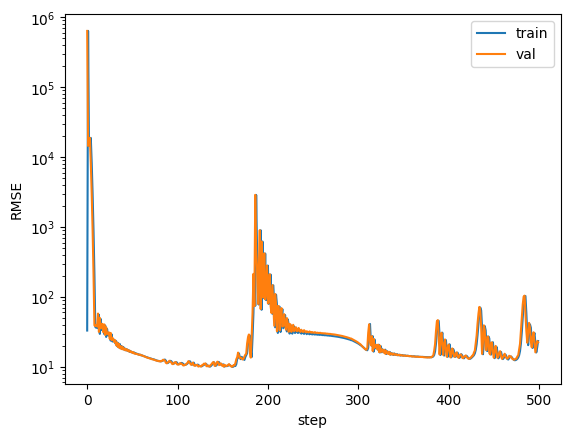

In [30]:
model0 = build_custom_cnn_model(cnn_blocks=3, dense_layers=1, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model0, dataset, steps=500, opt='AdamW', batch=-1)
model0.load_state_dict(model_state)
print(average_rmse(model0(0, dataset['test_img']), dataset['test_label']))
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

| Train: 1.3812e+01 | Val: 2.0169e+01 |: 100%|████████████████████| 500/500 [00:08<00:00, 58.59it/s]


✅ Best validation loss: 1.2486e+01 at 301 epoch
3.63124942779541


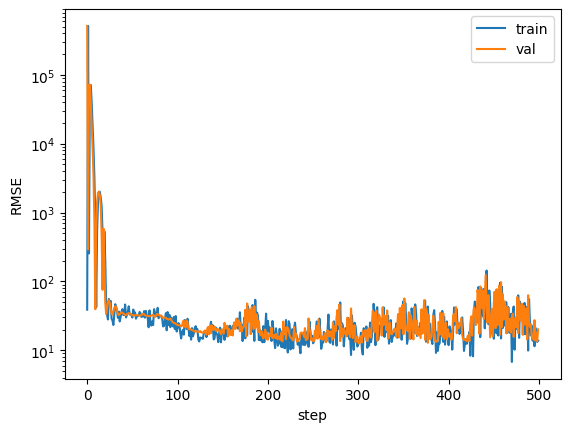

In [31]:
model0 = build_custom_cnn_model(cnn_blocks=3, dense_layers=1, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model0, dataset, steps=500, opt='AdamW', batch=32)
model0.load_state_dict(model_state)
print(average_rmse(model0(0, dataset['test_img']), dataset['test_label']))
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

# Grid Search for Hibrid Model3

In [26]:
class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, device=device):
        super(Model3, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.LayerNorm([16, 8, 8]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

## Grid Search

In [27]:
grid_search_kan_hybrid(dataset, Model3, max_steps=50)

Testing 1 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 4.01e-01 |: 100%|█| 50/50 [02:48<00:00,  3.37s/i


saving model version 0.1
✅ Best validation loss: 3.3283e+01 at 37 epoch
Testing 1 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.50e+00 | eval_loss: 3.15e+00 | reg: 2.24e+01 |: 100%|█| 50/50 [02:58<00:00,  3.57s/i


saving model version 0.1
✅ Best validation loss: 9.9004e+00 at 34 epoch
Testing 1 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.11e+00 | eval_loss: 3.14e+00 | reg: 4.36e+01 |: 100%|█| 50/50 [02:50<00:00,  3.41s/i


saving model version 0.1
✅ Best validation loss: 9.6061e+00 at 15 epoch
Testing 1 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.02e+00 | eval_loss: 3.19e+00 | reg: 1.93e+02 |: 100%|█| 50/50 [03:08<00:00,  3.77s/i


saving model version 0.1
✅ Best validation loss: 9.5796e+00 at 14 epoch
Testing 1 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.97e+00 | eval_loss: 3.24e+00 | reg: 3.58e+02 |: 100%|█| 50/50 [03:03<00:00,  3.67s/i


saving model version 0.1
✅ Best validation loss: 9.5369e+00 at 12 epoch
Testing 1 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.04e+00 | eval_loss: 3.13e+00 | reg: 3.32e+02 |: 100%|█| 50/50 [03:07<00:00,  3.75s/i


saving model version 0.1
✅ Best validation loss: 9.5958e+00 at 13 epoch
Testing 1 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.01e+00 | eval_loss: 3.19e+00 | reg: 4.94e+02 |: 100%|█| 50/50 [03:08<00:00,  3.76s/i


saving model version 0.1
✅ Best validation loss: 9.5867e+00 at 14 epoch
Testing 1 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 3.93e-01 |: 100%|█| 50/50 [03:10<00:00,  3.82s/i


saving model version 0.1
✅ Best validation loss: 3.3287e+01 at 49 epoch
Testing 1 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.52e+00 | eval_loss: 3.13e+00 | reg: 2.46e+01 |: 100%|█| 50/50 [03:17<00:00,  3.94s/i


saving model version 0.1
✅ Best validation loss: 9.7826e+00 at 22 epoch
Testing 1 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.06e+00 | eval_loss: 3.22e+00 | reg: 6.16e+01 |: 100%|█| 50/50 [03:14<00:00,  3.89s/i


saving model version 0.1
✅ Best validation loss: 9.5865e+00 at 7 epoch
Testing 1 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.87e+00 | eval_loss: 3.33e+00 | reg: 2.63e+02 |: 100%|█| 50/50 [03:13<00:00,  3.88s/i


saving model version 0.1
✅ Best validation loss: 9.5302e+00 at 9 epoch
Testing 1 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.78e+00 | eval_loss: 3.51e+00 | reg: 5.76e+02 |: 100%|█| 50/50 [03:15<00:00,  3.91s/i


saving model version 0.1
✅ Best validation loss: 9.6314e+00 at 4 epoch
Testing 1 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.85e+00 | eval_loss: 3.33e+00 | reg: 4.83e+02 |: 100%|█| 50/50 [03:45<00:00,  4.51s/i


saving model version 0.1
✅ Best validation loss: 9.5481e+00 at 7 epoch
Testing 1 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.89e+00 | eval_loss: 3.29e+00 | reg: 4.06e+02 |: 100%|█| 50/50 [03:22<00:00,  4.06s/i


saving model version 0.1
✅ Best validation loss: 9.5904e+00 at 9 epoch
Testing 1 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.65e+00 | eval_loss: 5.77e+00 | reg: 4.86e-01 |: 100%|█| 50/50 [03:31<00:00,  4.23s/i


saving model version 0.1
✅ Best validation loss: 3.3281e+01 at 44 epoch
Testing 1 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.52e+00 | eval_loss: 3.14e+00 | reg: 2.34e+01 |: 100%|█| 50/50 [03:40<00:00,  4.41s/i


saving model version 0.1
✅ Best validation loss: 9.8772e+00 at 39 epoch
Testing 1 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.06e+00 | eval_loss: 3.15e+00 | reg: 7.42e+01 |: 100%|█| 50/50 [03:40<00:00,  4.40s/i


saving model version 0.1
✅ Best validation loss: 9.5668e+00 at 8 epoch
Testing 1 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.78e+00 | eval_loss: 3.45e+00 | reg: 3.96e+02 |: 100%|█| 50/50 [03:35<00:00,  4.31s/i


saving model version 0.1
✅ Best validation loss: 9.5513e+00 at 3 epoch
Testing 1 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.75e+00 | eval_loss: 3.48e+00 | reg: 5.00e+02 |: 100%|█| 50/50 [03:42<00:00,  4.45s/i


saving model version 0.1
✅ Best validation loss: 9.5681e+00 at 5 epoch
Testing 1 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.74e+00 | eval_loss: 3.46e+00 | reg: 6.00e+02 |: 100%|█| 50/50 [03:41<00:00,  4.43s/i


saving model version 0.1
✅ Best validation loss: 9.5821e+00 at 3 epoch
Testing 1 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.75e+00 | eval_loss: 3.46e+00 | reg: 5.41e+02 |: 100%|█| 50/50 [03:35<00:00,  4.32s/i


saving model version 0.1
✅ Best validation loss: 9.5444e+00 at 8 epoch
Testing 1 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.63e+00 | eval_loss: 5.77e+00 | reg: 3.27e-01 |: 100%|█| 50/50 [03:52<00:00,  4.64s/i


saving model version 0.1
✅ Best validation loss: 3.3280e+01 at 49 epoch
Testing 1 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.54e+00 | eval_loss: 3.15e+00 | reg: 2.59e+01 |: 100%|█| 50/50 [03:52<00:00,  4.66s/i


saving model version 0.1
✅ Best validation loss: 9.8794e+00 at 34 epoch
Testing 1 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.01e+00 | eval_loss: 3.26e+00 | reg: 9.86e+01 |: 100%|█| 50/50 [03:54<00:00,  4.68s/i


saving model version 0.1
✅ Best validation loss: 9.5869e+00 at 10 epoch
Testing 1 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.58e+00 | eval_loss: 3.71e+00 | reg: 5.05e+02 |: 100%|█| 50/50 [03:51<00:00,  4.63s/i


saving model version 0.1
✅ Best validation loss: 9.5052e+00 at 7 epoch
Testing 1 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.69e+00 | eval_loss: 3.51e+00 | reg: 5.08e+02 |: 100%|█| 50/50 [03:53<00:00,  4.67s/i


saving model version 0.1
✅ Best validation loss: 9.5274e+00 at 7 epoch
Testing 1 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.61e+00 | eval_loss: 3.65e+00 | reg: 6.15e+02 |: 100%|█| 50/50 [03:55<00:00,  4.70s/i


saving model version 0.1
✅ Best validation loss: 9.5376e+00 at 8 epoch
Testing 1 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.65e+00 | eval_loss: 3.59e+00 | reg: 5.98e+02 |: 100%|█| 50/50 [03:52<00:00,  4.66s/i


saving model version 0.1
✅ Best validation loss: 9.5071e+00 at 9 epoch
Testing 2 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 3.82e-01 |: 100%|█| 50/50 [02:48<00:00,  3.38s/i


saving model version 0.1
✅ Best validation loss: 3.3277e+01 at 39 epoch
Testing 2 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.44e+00 | eval_loss: 3.14e+00 | reg: 1.90e+01 |: 100%|█| 50/50 [02:56<00:00,  3.53s/i


saving model version 0.1
✅ Best validation loss: 9.7977e+00 at 36 epoch
Testing 2 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.08e+00 | eval_loss: 3.16e+00 | reg: 5.07e+01 |: 100%|█| 50/50 [02:58<00:00,  3.58s/i


saving model version 0.1
✅ Best validation loss: 9.5155e+00 at 8 epoch
Testing 2 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.89e+00 | eval_loss: 3.27e+00 | reg: 2.17e+02 |: 100%|█| 50/50 [03:04<00:00,  3.69s/i


saving model version 0.1
✅ Best validation loss: 9.5657e+00 at 6 epoch
Testing 2 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.93e+00 | eval_loss: 3.25e+00 | reg: 3.25e+02 |: 100%|█| 50/50 [03:04<00:00,  3.69s/i


saving model version 0.1
✅ Best validation loss: 9.5244e+00 at 8 epoch
Testing 2 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.89e+00 | eval_loss: 3.32e+00 | reg: 3.95e+02 |: 100%|█| 50/50 [03:08<00:00,  3.76s/i


saving model version 0.1
✅ Best validation loss: 9.5506e+00 at 9 epoch
Testing 2 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.93e+00 | eval_loss: 3.26e+00 | reg: 5.08e+02 |: 100%|█| 50/50 [03:05<00:00,  3.71s/i


saving model version 0.1
✅ Best validation loss: 9.5175e+00 at 7 epoch
Testing 2 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 3.72e-01 |: 100%|█| 50/50 [03:05<00:00,  3.72s/i


saving model version 0.1
✅ Best validation loss: 3.3281e+01 at 32 epoch
Testing 2 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.50e+00 | eval_loss: 3.14e+00 | reg: 2.26e+01 |: 100%|█| 50/50 [03:09<00:00,  3.80s/i


saving model version 0.1
✅ Best validation loss: 9.7823e+00 at 14 epoch
Testing 2 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.06e+00 | eval_loss: 3.20e+00 | reg: 6.05e+01 |: 100%|█| 50/50 [03:10<00:00,  3.82s/i


saving model version 0.1
✅ Best validation loss: 9.5892e+00 at 6 epoch
Testing 2 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.03e+00 | eval_loss: 3.20e+00 | reg: 1.24e+02 |: 100%|█| 50/50 [03:00<00:00,  3.61s/i


saving model version 0.1
✅ Best validation loss: 9.5288e+00 at 7 epoch
Testing 2 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.81e+00 | eval_loss: 3.41e+00 | reg: 5.79e+02 |: 100%|█| 50/50 [03:15<00:00,  3.91s/i


saving model version 0.1
✅ Best validation loss: 9.6014e+00 at 4 epoch
Testing 2 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.75e+00 | eval_loss: 3.40e+00 | reg: 5.53e+02 |: 100%|█| 50/50 [03:12<00:00,  3.85s/i


saving model version 0.1
✅ Best validation loss: 9.5541e+00 at 7 epoch
Testing 2 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.76e+00 | eval_loss: 3.43e+00 | reg: 5.84e+02 |: 100%|█| 50/50 [03:12<00:00,  3.85s/i


saving model version 0.1
✅ Best validation loss: 9.5948e+00 at 6 epoch
Testing 2 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.63e+00 | eval_loss: 5.77e+00 | reg: 3.64e-01 |: 100%|█| 50/50 [03:20<00:00,  4.00s/i


saving model version 0.1
✅ Best validation loss: 3.3278e+01 at 29 epoch
Testing 2 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.44e+00 | eval_loss: 3.15e+00 | reg: 1.84e+01 |: 100%|█| 50/50 [03:25<00:00,  4.11s/i


saving model version 0.1
✅ Best validation loss: 9.8654e+00 at 38 epoch
Testing 2 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.04e+00 | eval_loss: 3.18e+00 | reg: 8.42e+01 |: 100%|█| 50/50 [03:35<00:00,  4.30s/i


saving model version 0.1
✅ Best validation loss: 9.5471e+00 at 6 epoch
Testing 2 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.73e+00 | eval_loss: 3.52e+00 | reg: 3.49e+02 |: 100%|█| 50/50 [03:33<00:00,  4.27s/i


saving model version 0.1
✅ Best validation loss: 9.5433e+00 at 5 epoch
Testing 2 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.69e+00 | eval_loss: 3.54e+00 | reg: 5.39e+02 |: 100%|█| 50/50 [03:32<00:00,  4.25s/i


saving model version 0.1
✅ Best validation loss: 9.5151e+00 at 5 epoch
Testing 2 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.70e+00 | eval_loss: 3.54e+00 | reg: 5.21e+02 |: 100%|█| 50/50 [03:35<00:00,  4.31s/i


saving model version 0.1
✅ Best validation loss: 9.5582e+00 at 8 epoch
Testing 2 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.69e+00 | eval_loss: 3.57e+00 | reg: 5.35e+02 |: 100%|█| 50/50 [03:31<00:00,  4.23s/i


saving model version 0.1
✅ Best validation loss: 9.5489e+00 at 5 epoch
Testing 2 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.63e+00 | eval_loss: 5.77e+00 | reg: 3.16e-01 |: 100%|█| 50/50 [03:43<00:00,  4.47s/i


saving model version 0.1
✅ Best validation loss: 3.3275e+01 at 45 epoch
Testing 2 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.49e+00 | eval_loss: 3.13e+00 | reg: 2.26e+01 |: 100%|█| 50/50 [03:48<00:00,  4.57s/i


saving model version 0.1
✅ Best validation loss: 9.7955e+00 at 47 epoch
Testing 2 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.00e+00 | eval_loss: 3.28e+00 | reg: 1.14e+02 |: 100%|█| 50/50 [03:53<00:00,  4.66s/i


saving model version 0.1
✅ Best validation loss: 9.6010e+00 at 11 epoch
Testing 2 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.55e+00 | eval_loss: 3.63e+00 | reg: 4.15e+02 |: 100%|█| 50/50 [03:53<00:00,  4.67s/i


saving model version 0.1
✅ Best validation loss: 9.5613e+00 at 8 epoch
Testing 2 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.78e+00 | eval_loss: 3.43e+00 | reg: 3.78e+02 |: 100%|█| 50/50 [04:03<00:00,  4.87s/i


saving model version 0.1
✅ Best validation loss: 9.5618e+00 at 10 epoch
Testing 2 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.65e+00 | eval_loss: 3.63e+00 | reg: 5.55e+02 |: 100%|█| 50/50 [03:59<00:00,  4.80s/i


saving model version 0.1
✅ Best validation loss: 9.5469e+00 at 4 epoch
Testing 2 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.52e+00 | eval_loss: 3.68e+00 | reg: 6.82e+02 |: 100%|█| 50/50 [03:50<00:00,  4.61s/i


saving model version 0.1
✅ Best validation loss: 9.5725e+00 at 7 epoch
Testing 3 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.65e+00 | eval_loss: 5.77e+00 | reg: 5.33e-01 |: 100%|█| 50/50 [02:49<00:00,  3.38s/i


saving model version 0.1
✅ Best validation loss: 3.3266e+01 at 13 epoch
Testing 3 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.47e+00 | eval_loss: 3.13e+00 | reg: 2.15e+01 |: 100%|█| 50/50 [02:51<00:00,  3.43s/i


saving model version 0.1
✅ Best validation loss: 9.7423e+00 at 42 epoch
Testing 3 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.10e+00 | eval_loss: 3.14e+00 | reg: 4.68e+01 |: 100%|█| 50/50 [02:58<00:00,  3.57s/i


saving model version 0.1
✅ Best validation loss: 9.5596e+00 at 6 epoch
Testing 3 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.90e+00 | eval_loss: 3.30e+00 | reg: 2.10e+02 |: 100%|█| 50/50 [03:03<00:00,  3.67s/i


saving model version 0.1
✅ Best validation loss: 9.5900e+00 at 12 epoch
Testing 3 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.92e+00 | eval_loss: 3.23e+00 | reg: 4.61e+02 |: 100%|█| 50/50 [03:06<00:00,  3.73s/i


saving model version 0.1
✅ Best validation loss: 9.5431e+00 at 16 epoch
Testing 3 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.91e+00 | eval_loss: 3.24e+00 | reg: 4.95e+02 |: 100%|█| 50/50 [03:05<00:00,  3.71s/i


saving model version 0.1
✅ Best validation loss: 9.5799e+00 at 7 epoch
Testing 3 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.90e+00 | eval_loss: 3.29e+00 | reg: 4.42e+02 |: 100%|█| 50/50 [03:01<00:00,  3.63s/i


saving model version 0.1
✅ Best validation loss: 9.5295e+00 at 11 epoch
Testing 3 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 4.32e-01 |: 100%|█| 50/50 [03:02<00:00,  3.65s/i


saving model version 0.1
✅ Best validation loss: 3.3276e+01 at 25 epoch
Testing 3 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.50e+00 | eval_loss: 3.15e+00 | reg: 2.27e+01 |: 100%|█| 50/50 [03:07<00:00,  3.75s/i


saving model version 0.1
✅ Best validation loss: 9.9059e+00 at 25 epoch
Testing 3 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.08e+00 | eval_loss: 3.17e+00 | reg: 5.27e+01 |: 100%|█| 50/50 [03:11<00:00,  3.82s/i


saving model version 0.1
✅ Best validation loss: 9.5794e+00 at 10 epoch
Testing 3 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.97e+00 | eval_loss: 3.23e+00 | reg: 2.02e+02 |: 100%|█| 50/50 [02:29<00:00,  3.00s/i


saving model version 0.1
✅ Best validation loss: 9.6118e+00 at 5 epoch
Testing 3 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.85e+00 | eval_loss: 3.32e+00 | reg: 4.79e+02 |: 100%|█| 50/50 [03:15<00:00,  3.91s/i


saving model version 0.1
✅ Best validation loss: 9.5829e+00 at 5 epoch
Testing 3 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.81e+00 | eval_loss: 3.36e+00 | reg: 5.14e+02 |: 100%|█| 50/50 [03:15<00:00,  3.91s/i


saving model version 0.1
✅ Best validation loss: 9.5406e+00 at 3 epoch
Testing 3 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.85e+00 | eval_loss: 3.32e+00 | reg: 5.81e+02 |: 100%|█| 50/50 [03:15<00:00,  3.91s/i


saving model version 0.1
✅ Best validation loss: 9.6015e+00 at 4 epoch
Testing 3 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 3.79e-01 |: 100%|█| 50/50 [03:18<00:00,  3.97s/i


saving model version 0.1
✅ Best validation loss: 3.3272e+01 at 14 epoch
Testing 3 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.49e+00 | eval_loss: 3.15e+00 | reg: 2.24e+01 |: 100%|█| 50/50 [03:22<00:00,  4.04s/i


saving model version 0.1
✅ Best validation loss: 9.8835e+00 at 40 epoch
Testing 3 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.14e+00 | eval_loss: 3.12e+00 | reg: 6.51e+01 |: 100%|█| 50/50 [02:31<00:00,  3.02s/i


saving model version 0.1
✅ Best validation loss: 9.5725e+00 at 12 epoch
Testing 3 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.67e+00 | eval_loss: 3.57e+00 | reg: 3.83e+02 |: 100%|█| 50/50 [03:30<00:00,  4.21s/i


saving model version 0.1
✅ Best validation loss: 9.6016e+00 at 6 epoch
Testing 3 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.73e+00 | eval_loss: 3.45e+00 | reg: 4.77e+02 |: 100%|█| 50/50 [03:32<00:00,  4.25s/i


saving model version 0.1
✅ Best validation loss: 9.5314e+00 at 4 epoch
Testing 3 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.70e+00 | eval_loss: 3.57e+00 | reg: 5.76e+02 |: 100%|█| 50/50 [03:31<00:00,  4.22s/i


saving model version 0.1
✅ Best validation loss: 9.5899e+00 at 5 epoch
Testing 3 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.75e+00 | eval_loss: 3.49e+00 | reg: 4.89e+02 |: 100%|█| 50/50 [03:41<00:00,  4.43s/i


saving model version 0.1
✅ Best validation loss: 9.5103e+00 at 5 epoch
Testing 3 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 4.66e-01 |: 100%|█| 50/50 [03:42<00:00,  4.44s/i


saving model version 0.1
✅ Best validation loss: 3.3271e+01 at 19 epoch
Testing 3 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.41e+00 | eval_loss: 3.14e+00 | reg: 1.69e+01 |: 100%|█| 50/50 [03:46<00:00,  4.53s/i


saving model version 0.1
✅ Best validation loss: 9.8094e+00 at 34 epoch
Testing 3 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: nan | eval_loss: nan | reg: nan |: 100%|██████████████| 50/50 [04:10<00:00,  5.01s/it]


saving model version 0.1
✅ Best validation loss: 9.5311e+00 at 6 epoch
Testing 3 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.54e+00 | eval_loss: 3.75e+00 | reg: 4.34e+02 |: 100%|█| 50/50 [03:55<00:00,  4.71s/i


saving model version 0.1
✅ Best validation loss: 9.5113e+00 at 6 epoch
Testing 3 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.76e+00 | eval_loss: 3.40e+00 | reg: 3.55e+02 |: 100%|█| 50/50 [04:07<00:00,  4.94s/i


saving model version 0.1
✅ Best validation loss: 9.5198e+00 at 4 epoch
Testing 3 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.66e+00 | eval_loss: 3.52e+00 | reg: 4.40e+02 |: 100%|█| 50/50 [04:02<00:00,  4.85s/i


saving model version 0.1
✅ Best validation loss: 9.5270e+00 at 7 epoch
Testing 3 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.63e+00 | eval_loss: 3.54e+00 | reg: 4.45e+02 |: 100%|█| 50/50 [03:59<00:00,  4.78s/i


saving model version 0.1
✅ Best validation loss: 9.5352e+00 at 6 epoch
Testing 4 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 4.64e-01 |: 100%|█| 50/50 [02:49<00:00,  3.40s/i


saving model version 0.1
✅ Best validation loss: 3.3266e+01 at 15 epoch
Testing 4 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.50e+00 | eval_loss: 3.14e+00 | reg: 2.22e+01 |: 100%|█| 50/50 [02:53<00:00,  3.47s/i


saving model version 0.1
✅ Best validation loss: 9.8685e+00 at 18 epoch
Testing 4 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.09e+00 | eval_loss: 3.16e+00 | reg: 5.08e+01 |: 100%|█| 50/50 [03:01<00:00,  3.62s/i


saving model version 0.1
✅ Best validation loss: 9.5434e+00 at 10 epoch
Testing 4 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.90e+00 | eval_loss: 3.32e+00 | reg: 2.26e+02 |: 100%|█| 50/50 [03:02<00:00,  3.65s/i


saving model version 0.1
✅ Best validation loss: 9.5418e+00 at 6 epoch
Testing 4 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.88e+00 | eval_loss: 3.29e+00 | reg: 4.29e+02 |: 100%|█| 50/50 [03:08<00:00,  3.76s/i


saving model version 0.1
✅ Best validation loss: 9.5680e+00 at 4 epoch
Testing 4 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.89e+00 | eval_loss: 3.28e+00 | reg: 4.50e+02 |: 100%|█| 50/50 [03:00<00:00,  3.60s/i


saving model version 0.1
✅ Best validation loss: 9.5591e+00 at 9 epoch
Testing 4 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.88e+00 | eval_loss: 3.32e+00 | reg: 4.40e+02 |: 100%|█| 50/50 [03:08<00:00,  3.77s/i


saving model version 0.1
✅ Best validation loss: 9.5424e+00 at 4 epoch
Testing 4 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.65e+00 | eval_loss: 5.77e+00 | reg: 5.98e-01 |: 100%|█| 50/50 [03:02<00:00,  3.65s/i


saving model version 0.1
✅ Best validation loss: 3.3269e+01 at 12 epoch
Testing 4 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.41e+00 | eval_loss: 3.14e+00 | reg: 1.68e+01 |: 100%|█| 50/50 [03:10<00:00,  3.82s/i


saving model version 0.1
✅ Best validation loss: 9.7644e+00 at 12 epoch
Testing 4 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.07e+00 | eval_loss: 3.19e+00 | reg: 5.86e+01 |: 100%|█| 50/50 [03:07<00:00,  3.74s/i


saving model version 0.1
✅ Best validation loss: 9.5812e+00 at 9 epoch
Testing 4 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.90e+00 | eval_loss: 3.32e+00 | reg: 2.29e+02 |: 100%|█| 50/50 [03:15<00:00,  3.91s/i


saving model version 0.1
✅ Best validation loss: 9.5274e+00 at 8 epoch
Testing 4 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.79e+00 | eval_loss: 3.39e+00 | reg: 5.21e+02 |: 100%|█| 50/50 [03:13<00:00,  3.88s/i


saving model version 0.1
✅ Best validation loss: 9.5412e+00 at 8 epoch
Testing 4 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.81e+00 | eval_loss: 3.42e+00 | reg: 5.82e+02 |: 100%|█| 50/50 [03:21<00:00,  4.04s/i


saving model version 0.1
✅ Best validation loss: 9.5874e+00 at 7 epoch
Testing 4 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.86e+00 | eval_loss: 3.31e+00 | reg: 4.65e+02 |: 100%|█| 50/50 [03:20<00:00,  4.01s/i


saving model version 0.1
✅ Best validation loss: 9.5770e+00 at 9 epoch
Testing 4 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.65e+00 | eval_loss: 5.77e+00 | reg: 5.06e-01 |: 100%|█| 50/50 [03:20<00:00,  4.00s/i


saving model version 0.1
✅ Best validation loss: 3.3267e+01 at 15 epoch
Testing 4 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.48e+00 | eval_loss: 3.14e+00 | reg: 2.16e+01 |: 100%|█| 50/50 [03:19<00:00,  3.99s/i


saving model version 0.1
✅ Best validation loss: 9.8501e+00 at 12 epoch
Testing 4 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.02e+00 | eval_loss: 3.28e+00 | reg: 8.95e+01 |: 100%|█| 50/50 [03:33<00:00,  4.27s/i


saving model version 0.1
✅ Best validation loss: 9.6165e+00 at 7 epoch
Testing 4 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.65e+00 | eval_loss: 3.61e+00 | reg: 2.97e+02 |: 100%|█| 50/50 [03:34<00:00,  4.28s/i


saving model version 0.1
✅ Best validation loss: 9.5192e+00 at 4 epoch
Testing 4 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.67e+00 | eval_loss: 3.55e+00 | reg: 4.49e+02 |: 100%|█| 50/50 [03:34<00:00,  4.30s/i


saving model version 0.1
✅ Best validation loss: 9.5605e+00 at 6 epoch
Testing 4 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.67e+00 | eval_loss: 3.68e+00 | reg: 5.29e+02 |: 100%|█| 50/50 [03:27<00:00,  4.16s/i


saving model version 0.1
✅ Best validation loss: 9.5640e+00 at 9 epoch
Testing 4 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.67e+00 | eval_loss: 3.51e+00 | reg: 5.41e+02 |: 100%|█| 50/50 [03:31<00:00,  4.24s/i


saving model version 0.1
✅ Best validation loss: 9.6052e+00 at 8 epoch
Testing 4 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.65e+00 | eval_loss: 5.77e+00 | reg: 5.29e-01 |: 100%|█| 50/50 [03:44<00:00,  4.48s/i


saving model version 0.1
✅ Best validation loss: 3.3271e+01 at 17 epoch
Testing 4 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.49e+00 | eval_loss: 3.14e+00 | reg: 2.24e+01 |: 100%|█| 50/50 [03:46<00:00,  4.52s/i


saving model version 0.1
✅ Best validation loss: 9.8610e+00 at 38 epoch
Testing 4 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.03e+00 | eval_loss: 3.25e+00 | reg: 8.55e+01 |: 100%|█| 50/50 [03:56<00:00,  4.73s/i


saving model version 0.1
✅ Best validation loss: 9.5063e+00 at 11 epoch
Testing 4 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.63e+00 | eval_loss: 3.62e+00 | reg: 3.16e+02 |: 100%|█| 50/50 [03:47<00:00,  4.55s/i


saving model version 0.1
✅ Best validation loss: 9.5738e+00 at 4 epoch
Testing 4 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.63e+00 | eval_loss: 3.50e+00 | reg: 4.12e+02 |: 100%|█| 50/50 [04:00<00:00,  4.80s/i


saving model version 0.1
✅ Best validation loss: 9.5222e+00 at 8 epoch
Testing 4 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.51e+00 | eval_loss: 3.66e+00 | reg: 5.84e+02 |: 100%|█| 50/50 [03:56<00:00,  4.72s/i


saving model version 0.1
✅ Best validation loss: 9.6425e+00 at 8 epoch
Testing 4 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 2.59e+00 | eval_loss: 3.62e+00 | reg: 5.25e+02 |: 100%|█| 50/50 [03:53<00:00,  4.67s/i

saving model version 0.1
✅ Best validation loss: 9.5809e+00 at 6 epoch

✅ Top 5 Configurations:
1. width=[8, 4, 1], grid=3, lamb=0.01| best_epoch=10 | loss=3.21696
2. width=[8, 3, 1], grid=5, lamb=0.01| best_epoch=12 | loss=3.21744
3. width=[8, 3, 1], grid=4, lamb=0.01| best_epoch=10 | loss=3.22009
4. width=[8, 4, 1], grid=4, lamb=0.01| best_epoch=9 | loss=3.22056
5. width=[8, 4, 1], grid=4, lamb=0.001| best_epoch=8 | loss=3.22094


# ✅ Top 5 Configurations:
1. width=[8, 4, 1], grid=4, lamb=0.01| best_epoch=8 | loss=3.21745
2. width=[8, 4, 1], grid=3, lamb=0.01| best_epoch=11 | loss=3.21929
3. width=[8, 1, 1], grid=5, lamb=0.01| best_epoch=9 | loss=3.22133
4. width=[8, 4, 1], grid=3, lamb=1e-05| best_epoch=4 | loss=3.22212
5. width=[8, 3, 1], grid=4, lamb=0.01| best_epoch=9 | loss=3.22233

In [ ]:
model3 = try_create_model(Model3, attributes, imgs_shape, kan_neurons=7, kan_grid=4)  # Attempt to create Model3
best_model_state, metrics3, best_epoch = fit_hybrid_dataloaders(model3, dataset, opt="LBFGS", steps=10, lamb=1e-05)
model3.load_state_dict(best_model_state)
print(average_rmse(model3(dataset['test_input'], dataset['test_img']), dataset['test_label']))
plt.plot(metrics3['train_loss'])
plt.plot(metrics3['eval_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [ ]:
model3.m_kan.plot()

In [ ]:
plot_sorted_feature_importance(x_col, model3.m_kan.feature_score)

In [ ]:
model3.final_kan.plot()

In [ ]:
feature_score = model3.final_kan.feature_score

In [ ]:
plot_mkan_vs_cnn_relevance(feature_score, mkan_len=kan_neurons)

In [29]:
class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, device=device):
        super(Model4, self).__init__()

        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 6, 6]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Middle KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            device=device
        )
        
        self.device = device

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [30]:
grid_search_kan_hybrid(dataset, Model4, max_steps=50)

Testing 1 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.63e+00 | eval_loss: 5.77e+00 | reg: 2.72e-01 |: 100%|█| 50/50 [03:11<00:00,  3.83s/i


saving model version 0.1
✅ Best validation loss: 3.3267e+01 at 11 epoch
Testing 1 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.35e+00 | eval_loss: 3.13e+00 | reg: 2.02e+01 |: 100%|█| 50/50 [03:17<00:00,  3.95s/i


saving model version 0.1
✅ Best validation loss: 9.7101e+00 at 8 epoch
Testing 1 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.35e+00 | eval_loss: 3.85e+00 | reg: 6.75e+01 |: 100%|█| 50/50 [03:13<00:00,  3.87s/i


saving model version 0.1
✅ Best validation loss: 9.5744e+00 at 5 epoch
Testing 1 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.16e+00 | eval_loss: 4.10e+00 | reg: 3.96e+02 |: 100%|█| 50/50 [03:13<00:00,  3.88s/i


saving model version 0.1
✅ Best validation loss: 9.6269e+00 at 4 epoch
Testing 1 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.09e+00 | eval_loss: 4.02e+00 | reg: 5.02e+02 |: 100%|█| 50/50 [03:16<00:00,  3.93s/i


saving model version 0.1
✅ Best validation loss: 9.6780e+00 at 3 epoch
Testing 1 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.20e+00 | eval_loss: 3.92e+00 | reg: 5.81e+02 |: 100%|█| 50/50 [03:18<00:00,  3.97s/i


saving model version 0.1
✅ Best validation loss: 9.6478e+00 at 5 epoch
Testing 1 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.07e+00 | eval_loss: 4.20e+00 | reg: 5.85e+02 |: 100%|█| 50/50 [03:18<00:00,  3.97s/i


saving model version 0.1
✅ Best validation loss: 9.6681e+00 at 4 epoch
Testing 1 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.63e+00 | eval_loss: 5.77e+00 | reg: 2.76e-01 |: 100%|█| 50/50 [03:27<00:00,  4.15s/i


saving model version 0.1
✅ Best validation loss: 3.3278e+01 at 30 epoch
Testing 1 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.35e+00 | eval_loss: 3.16e+00 | reg: 2.17e+01 |: 100%|█| 50/50 [03:13<00:00,  3.88s/i


saving model version 0.1
✅ Best validation loss: 9.8340e+00 at 8 epoch
Testing 1 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.25e+00 | eval_loss: 3.84e+00 | reg: 9.14e+01 |: 100%|█| 50/50 [03:31<00:00,  4.23s/i


saving model version 0.1
✅ Best validation loss: 9.6101e+00 at 7 epoch
Testing 1 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.83e+00 | eval_loss: 4.35e+00 | reg: 4.32e+02 |: 100%|█| 50/50 [03:33<00:00,  4.28s/i


saving model version 0.1
✅ Best validation loss: 9.7355e+00 at 5 epoch
Testing 1 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.07e+00 | eval_loss: 4.11e+00 | reg: 6.48e+02 |: 100%|█| 50/50 [03:33<00:00,  4.26s/i


saving model version 0.1
✅ Best validation loss: 9.6866e+00 at 4 epoch
Testing 1 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.95e+00 | eval_loss: 4.18e+00 | reg: 7.97e+02 |: 100%|█| 50/50 [03:33<00:00,  4.26s/i


saving model version 0.1
✅ Best validation loss: 9.6459e+00 at 4 epoch
Testing 1 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.03e+00 | eval_loss: 4.05e+00 | reg: 7.29e+02 |: 100%|█| 50/50 [03:32<00:00,  4.26s/i


saving model version 0.1
✅ Best validation loss: 9.7485e+00 at 4 epoch
Testing 1 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.63e+00 | eval_loss: 5.77e+00 | reg: 2.66e-01 |: 100%|█| 50/50 [03:59<00:00,  4.78s/i


saving model version 0.1
✅ Best validation loss: 3.3281e+01 at 39 epoch
Testing 1 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.29e+00 | eval_loss: 3.21e+00 | reg: 2.17e+01 |: 100%|█| 50/50 [04:05<00:00,  4.91s/i


saving model version 0.1
✅ Best validation loss: 9.7336e+00 at 11 epoch
Testing 1 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.89e+00 | eval_loss: 4.13e+00 | reg: 1.44e+02 |: 100%|█| 50/50 [03:59<00:00,  4.78s/i


saving model version 0.1
✅ Best validation loss: 9.6467e+00 at 6 epoch
Testing 1 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.46e+00 | eval_loss: 4.68e+00 | reg: 5.86e+02 |: 100%|█| 50/50 [05:41<00:00,  6.83s/i


saving model version 0.1
✅ Best validation loss: 9.6743e+00 at 4 epoch
Testing 1 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.34e+00 | eval_loss: 4.76e+00 | reg: 6.36e+02 |: 100%|█| 50/50 [04:03<00:00,  4.86s/i


saving model version 0.1
✅ Best validation loss: 9.6665e+00 at 6 epoch
Testing 1 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.25e+00 | eval_loss: 4.70e+00 | reg: 6.57e+02 |: 100%|█| 50/50 [04:27<00:00,  5.35s/i


saving model version 0.1
✅ Best validation loss: 9.6843e+00 at 5 epoch
Testing 1 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.49e+00 | eval_loss: 4.59e+00 | reg: 6.08e+02 |: 100%|█| 50/50 [03:59<00:00,  4.78s/i


saving model version 0.1
✅ Best validation loss: 9.6463e+00 at 4 epoch
Testing 1 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.62e+00 | eval_loss: 5.77e+00 | reg: 2.45e-01 |: 100%|█| 50/50 [04:21<00:00,  5.23s/i


saving model version 0.1
✅ Best validation loss: 3.3276e+01 at 21 epoch
Testing 1 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.36e+00 | eval_loss: 3.17e+00 | reg: 2.28e+01 |: 100%|█| 50/50 [04:28<00:00,  5.38s/i


saving model version 0.1
✅ Best validation loss: 9.7770e+00 at 6 epoch
Testing 1 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.19e+00 | eval_loss: 3.86e+00 | reg: 1.42e+02 |: 100%|█| 50/50 [05:10<00:00,  6.21s/i


saving model version 0.1
✅ Best validation loss: 9.6416e+00 at 5 epoch
Testing 1 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.72e+00 | eval_loss: 4.31e+00 | reg: 6.17e+02 |: 100%|█| 50/50 [04:22<00:00,  5.24s/i


saving model version 0.1
✅ Best validation loss: 9.6683e+00 at 5 epoch
Testing 1 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.70e+00 | eval_loss: 4.40e+00 | reg: 7.84e+02 |: 100%|█| 50/50 [04:23<00:00,  5.28s/i


saving model version 0.1
✅ Best validation loss: 9.6369e+00 at 5 epoch
Testing 1 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.57e+00 | eval_loss: 4.37e+00 | reg: 8.56e+02 |: 100%|█| 50/50 [04:21<00:00,  5.22s/i


saving model version 0.1
✅ Best validation loss: 9.6301e+00 at 6 epoch
Testing 1 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.64e+00 | eval_loss: 4.55e+00 | reg: 9.18e+02 |: 100%|█| 50/50 [04:20<00:00,  5.21s/i


saving model version 0.1
✅ Best validation loss: 9.6231e+00 at 3 epoch
Testing 2 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.63e+00 | eval_loss: 5.77e+00 | reg: 3.03e-01 |: 100%|█| 50/50 [03:10<00:00,  3.80s/i


saving model version 0.1
✅ Best validation loss: 3.3267e+01 at 19 epoch
Testing 2 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.26e+00 | eval_loss: 3.21e+00 | reg: 1.97e+01 |: 100%|█| 50/50 [03:10<00:00,  3.82s/i


saving model version 0.1
✅ Best validation loss: 9.7890e+00 at 10 epoch
Testing 2 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.47e+00 | eval_loss: 3.65e+00 | reg: 8.05e+01 |: 100%|█| 50/50 [03:11<00:00,  3.83s/i


saving model version 0.1
✅ Best validation loss: 9.7830e+00 at 6 epoch
Testing 2 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.84e+00 | eval_loss: 4.36e+00 | reg: 3.34e+02 |: 100%|█| 50/50 [03:18<00:00,  3.98s/i


saving model version 0.1
✅ Best validation loss: 9.6146e+00 at 7 epoch
Testing 2 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.04e+00 | eval_loss: 4.10e+00 | reg: 5.84e+02 |: 100%|█| 50/50 [03:17<00:00,  3.94s/i


saving model version 0.1
✅ Best validation loss: 9.7621e+00 at 5 epoch
Testing 2 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.37e+00 | eval_loss: 3.74e+00 | reg: 6.86e+02 |: 100%|█| 50/50 [03:21<00:00,  4.04s/i


saving model version 0.1
✅ Best validation loss: 9.8639e+00 at 5 epoch
Testing 2 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.09e+00 | eval_loss: 4.09e+00 | reg: 7.01e+02 |: 100%|█| 50/50 [03:21<00:00,  4.02s/i


saving model version 0.1
✅ Best validation loss: 9.7536e+00 at 5 epoch
Testing 2 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.63e+00 | eval_loss: 5.77e+00 | reg: 3.38e-01 |: 100%|█| 50/50 [03:26<00:00,  4.13s/i


saving model version 0.1
✅ Best validation loss: 3.3273e+01 at 17 epoch
Testing 2 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.23e+00 | eval_loss: 3.24e+00 | reg: 2.22e+01 |: 100%|█| 50/50 [03:25<00:00,  4.12s/i


saving model version 0.1
✅ Best validation loss: 9.7482e+00 at 7 epoch
Testing 2 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.91e+00 | eval_loss: 4.16e+00 | reg: 8.81e+01 |: 100%|█| 50/50 [03:29<00:00,  4.19s/i


saving model version 0.1
✅ Best validation loss: 9.6164e+00 at 4 epoch
Testing 2 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.54e+00 | eval_loss: 4.43e+00 | reg: 3.26e+02 |: 100%|█| 50/50 [03:33<00:00,  4.26s/i


saving model version 0.1
✅ Best validation loss: 9.7544e+00 at 5 epoch
Testing 2 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.68e+00 | eval_loss: 4.39e+00 | reg: 5.17e+02 |: 100%|█| 50/50 [03:35<00:00,  4.31s/i


saving model version 0.1
✅ Best validation loss: 9.7339e+00 at 4 epoch
Testing 2 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.66e+00 | eval_loss: 4.38e+00 | reg: 6.35e+02 |: 100%|█| 50/50 [03:39<00:00,  4.38s/i


saving model version 0.1
✅ Best validation loss: 9.6964e+00 at 4 epoch
Testing 2 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.89e+00 | eval_loss: 4.09e+00 | reg: 6.98e+02 |: 100%|█| 50/50 [03:36<00:00,  4.33s/i


saving model version 0.1
✅ Best validation loss: 9.7595e+00 at 6 epoch
Testing 2 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.63e+00 | eval_loss: 5.77e+00 | reg: 2.85e-01 |: 100%|█| 50/50 [03:58<00:00,  4.78s/i


saving model version 0.1
✅ Best validation loss: 3.3270e+01 at 12 epoch
Testing 2 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.23e+00 | eval_loss: 3.24e+00 | reg: 2.13e+01 |: 100%|█| 50/50 [04:02<00:00,  4.85s/i


saving model version 0.1
✅ Best validation loss: 9.8342e+00 at 21 epoch
Testing 2 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.06e+00 | eval_loss: 3.98e+00 | reg: 1.30e+02 |: 100%|█| 50/50 [03:58<00:00,  4.76s/i


saving model version 0.1
✅ Best validation loss: 9.6504e+00 at 5 epoch
Testing 2 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.66e+00 | eval_loss: 4.36e+00 | reg: 4.49e+02 |: 100%|█| 50/50 [04:02<00:00,  4.84s/i


saving model version 0.1
✅ Best validation loss: 9.6208e+00 at 7 epoch
Testing 2 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.49e+00 | eval_loss: 4.50e+00 | reg: 6.33e+02 |: 100%|█| 50/50 [04:02<00:00,  4.86s/i


saving model version 0.1
✅ Best validation loss: 9.7010e+00 at 5 epoch
Testing 2 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.67e+00 | eval_loss: 4.42e+00 | reg: 6.44e+02 |: 100%|█| 50/50 [04:03<00:00,  4.88s/i


saving model version 0.1
✅ Best validation loss: 9.7098e+00 at 3 epoch
Testing 2 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.75e+00 | eval_loss: 4.37e+00 | reg: 6.57e+02 |: 100%|█| 50/50 [04:03<00:00,  4.87s/i


saving model version 0.1
✅ Best validation loss: 9.6796e+00 at 3 epoch
Testing 2 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.62e+00 | eval_loss: 5.77e+00 | reg: 2.34e-01 |: 100%|█| 50/50 [04:21<00:00,  5.23s/i


saving model version 0.1
✅ Best validation loss: 3.3271e+01 at 17 epoch
Testing 2 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.16e+00 | eval_loss: 3.35e+00 | reg: 2.41e+01 |: 100%|█| 50/50 [04:21<00:00,  5.23s/i


saving model version 0.1
✅ Best validation loss: 9.8385e+00 at 12 epoch
Testing 2 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.99e+00 | eval_loss: 4.03e+00 | reg: 1.34e+02 |: 100%|█| 50/50 [04:25<00:00,  5.31s/i


saving model version 0.1
✅ Best validation loss: 9.5532e+00 at 7 epoch
Testing 2 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.52e+00 | eval_loss: 4.50e+00 | reg: 4.78e+02 |: 100%|█| 50/50 [04:23<00:00,  5.26s/i


saving model version 0.1
✅ Best validation loss: 9.6893e+00 at 4 epoch
Testing 2 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.29e+00 | eval_loss: 4.70e+00 | reg: 6.75e+02 |: 100%|█| 50/50 [04:24<00:00,  5.30s/i


saving model version 0.1
✅ Best validation loss: 9.7583e+00 at 2 epoch
Testing 2 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.32e+00 | eval_loss: 4.57e+00 | reg: 7.16e+02 |: 100%|█| 50/50 [04:21<00:00,  5.23s/i


saving model version 0.1
✅ Best validation loss: 9.6716e+00 at 3 epoch
Testing 2 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.22e+00 | eval_loss: 4.74e+00 | reg: 6.99e+02 |: 100%|█| 50/50 [04:27<00:00,  5.34s/i


saving model version 0.1
✅ Best validation loss: 9.7069e+00 at 4 epoch
Testing 3 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.65e+00 | eval_loss: 5.77e+00 | reg: 5.32e-01 |: 100%|█| 50/50 [03:10<00:00,  3.82s/i


saving model version 0.1
✅ Best validation loss: 3.3266e+01 at 25 epoch
Testing 3 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.28e+00 | eval_loss: 3.15e+00 | reg: 2.04e+01 |: 100%|█| 50/50 [03:09<00:00,  3.78s/i


saving model version 0.1
✅ Best validation loss: 9.6637e+00 at 23 epoch
Testing 3 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.20e+00 | eval_loss: 3.87e+00 | reg: 8.05e+01 |: 100%|█| 50/50 [03:17<00:00,  3.95s/i


saving model version 0.1
✅ Best validation loss: 9.6873e+00 at 5 epoch
Testing 3 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.92e+00 | eval_loss: 4.20e+00 | reg: 3.41e+02 |: 100%|█| 50/50 [03:17<00:00,  3.95s/i


saving model version 0.1
✅ Best validation loss: 9.7102e+00 at 5 epoch
Testing 3 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.81e+00 | eval_loss: 4.14e+00 | reg: 4.00e+02 |: 100%|█| 50/50 [03:21<00:00,  4.03s/i


saving model version 0.1
✅ Best validation loss: 9.7315e+00 at 4 epoch
Testing 3 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.85e+00 | eval_loss: 4.29e+00 | reg: 5.64e+02 |: 100%|█| 50/50 [03:21<00:00,  4.03s/i


saving model version 0.1
✅ Best validation loss: 9.8402e+00 at 4 epoch
Testing 3 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.88e+00 | eval_loss: 4.10e+00 | reg: 5.55e+02 |: 100%|█| 50/50 [03:24<00:00,  4.09s/i


saving model version 0.1
✅ Best validation loss: 9.7835e+00 at 4 epoch
Testing 3 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 4.05e-01 |: 100%|█| 50/50 [03:28<00:00,  4.18s/i


saving model version 0.1
✅ Best validation loss: 3.3270e+01 at 10 epoch
Testing 3 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.16e+00 | eval_loss: 3.25e+00 | reg: 2.14e+01 |: 100%|█| 50/50 [03:28<00:00,  4.17s/i


saving model version 0.1
✅ Best validation loss: 9.6998e+00 at 8 epoch
Testing 3 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.98e+00 | eval_loss: 4.01e+00 | reg: 1.10e+02 |: 100%|█| 50/50 [03:30<00:00,  4.21s/i


saving model version 0.1
✅ Best validation loss: 9.7651e+00 at 5 epoch
Testing 3 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.87e+00 | eval_loss: 4.15e+00 | reg: 3.88e+02 |: 100%|█| 50/50 [03:31<00:00,  4.23s/i


saving model version 0.1
✅ Best validation loss: 9.7344e+00 at 5 epoch
Testing 3 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.82e+00 | eval_loss: 4.22e+00 | reg: 6.88e+02 |: 100%|█| 50/50 [03:37<00:00,  4.35s/i


saving model version 0.1
✅ Best validation loss: 9.7362e+00 at 6 epoch
Testing 3 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.88e+00 | eval_loss: 4.35e+00 | reg: 7.68e+02 |: 100%|█| 50/50 [03:37<00:00,  4.35s/i


saving model version 0.1
✅ Best validation loss: 9.8614e+00 at 4 epoch
Testing 3 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.07e+00 | eval_loss: 3.94e+00 | reg: 7.29e+02 |: 100%|█| 50/50 [03:33<00:00,  4.27s/i


saving model version 0.1
✅ Best validation loss: 9.8371e+00 at 3 epoch
Testing 3 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.63e+00 | eval_loss: 5.77e+00 | reg: 3.19e-01 |: 100%|█| 50/50 [03:58<00:00,  4.76s/i


saving model version 0.1
✅ Best validation loss: 3.3268e+01 at 10 epoch
Testing 3 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.01e+00 | eval_loss: 3.46e+00 | reg: 2.41e+01 |: 100%|█| 50/50 [03:54<00:00,  4.69s/i


saving model version 0.1
✅ Best validation loss: 9.7539e+00 at 6 epoch
Testing 3 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.08e+00 | eval_loss: 4.17e+00 | reg: 1.16e+02 |: 100%|█| 50/50 [03:53<00:00,  4.67s/i


saving model version 0.1
✅ Best validation loss: 9.6332e+00 at 5 epoch
Testing 3 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.74e+00 | eval_loss: 4.40e+00 | reg: 4.82e+02 |: 100%|█| 50/50 [04:00<00:00,  4.80s/i


saving model version 0.1
✅ Best validation loss: 9.6447e+00 at 4 epoch
Testing 3 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.50e+00 | eval_loss: 4.45e+00 | reg: 8.34e+02 |: 100%|█| 50/50 [04:05<00:00,  4.91s/i


saving model version 0.1
✅ Best validation loss: 9.5847e+00 at 4 epoch
Testing 3 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.50e+00 | eval_loss: 4.59e+00 | reg: 8.53e+02 |: 100%|█| 50/50 [03:59<00:00,  4.79s/i


saving model version 0.1
✅ Best validation loss: 9.6839e+00 at 5 epoch
Testing 3 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.64e+00 | eval_loss: 4.49e+00 | reg: 8.83e+02 |: 100%|█| 50/50 [04:01<00:00,  4.83s/i


saving model version 0.1
✅ Best validation loss: 9.6244e+00 at 4 epoch
Testing 3 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 4.16e-01 |: 100%|█| 50/50 [09:41<00:00, 11.63s/i


saving model version 0.1
✅ Best validation loss: 3.3266e+01 at 14 epoch
Testing 3 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.18e+00 | eval_loss: 3.30e+00 | reg: 2.36e+01 |: 100%|█| 50/50 [08:02<00:00,  9.64s/i


saving model version 0.1
✅ Best validation loss: 9.6894e+00 at 8 epoch
Testing 3 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.81e+00 | eval_loss: 4.23e+00 | reg: 1.26e+02 |: 100%|█| 50/50 [09:52<00:00, 11.84s/i


saving model version 0.1
✅ Best validation loss: 9.6264e+00 at 6 epoch
Testing 3 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.34e+00 | eval_loss: 4.65e+00 | reg: 4.94e+02 |: 100%|█| 50/50 [09:36<00:00, 11.53s/i


saving model version 0.1
✅ Best validation loss: 9.7481e+00 at 5 epoch
Testing 3 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.19e+00 | eval_loss: 4.68e+00 | reg: 6.20e+02 |: 100%|█| 50/50 [07:34<00:00,  9.09s/i


saving model version 0.1
✅ Best validation loss: 9.7495e+00 at 3 epoch
Testing 3 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.12e+00 | eval_loss: 4.75e+00 | reg: 6.43e+02 |: 100%|█| 50/50 [07:31<00:00,  9.03s/i


saving model version 0.1
✅ Best validation loss: 9.7641e+00 at 3 epoch
Testing 3 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.07e+00 | eval_loss: 4.66e+00 | reg: 6.00e+02 |: 100%|█| 50/50 [07:34<00:00,  9.09s/i


saving model version 0.1
✅ Best validation loss: 9.6866e+00 at 3 epoch
Testing 4 hidden neurons, lamb=1.0, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 4.64e-01 |: 100%|█| 50/50 [03:09<00:00,  3.78s/i


saving model version 0.1
✅ Best validation loss: 3.3266e+01 at 12 epoch
Testing 4 hidden neurons, lamb=0.1, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.25e+00 | eval_loss: 3.18e+00 | reg: 1.94e+01 |: 100%|█| 50/50 [03:16<00:00,  3.92s/i


saving model version 0.1
✅ Best validation loss: 9.7256e+00 at 6 epoch
Testing 4 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.39e+00 | eval_loss: 3.60e+00 | reg: 6.96e+01 |: 100%|█| 50/50 [03:11<00:00,  3.83s/i


saving model version 0.1
✅ Best validation loss: 9.6753e+00 at 3 epoch
Testing 4 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.47e+00 | eval_loss: 3.75e+00 | reg: 2.66e+02 |: 100%|█| 50/50 [03:32<00:00,  4.24s/i


saving model version 0.1
✅ Best validation loss: 9.6373e+00 at 6 epoch
Testing 4 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.08e+00 | eval_loss: 3.96e+00 | reg: 5.39e+02 |: 100%|█| 50/50 [03:13<00:00,  3.87s/i


saving model version 0.1
✅ Best validation loss: 9.8055e+00 at 5 epoch
Testing 4 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.35e+00 | eval_loss: 3.74e+00 | reg: 6.80e+02 |: 100%|█| 50/50 [03:15<00:00,  3.91s/i


saving model version 0.1
✅ Best validation loss: 9.6467e+00 at 3 epoch
Testing 4 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.05e+00 | eval_loss: 4.06e+00 | reg: 5.41e+02 |: 100%|█| 50/50 [03:18<00:00,  3.96s/i


saving model version 0.1
✅ Best validation loss: 9.6114e+00 at 5 epoch
Testing 4 hidden neurons, lamb=1.0, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.65e+00 | eval_loss: 5.77e+00 | reg: 4.87e-01 |: 100%|█| 50/50 [03:27<00:00,  4.16s/i


saving model version 0.1
✅ Best validation loss: 3.3266e+01 at 9 epoch
Testing 4 hidden neurons, lamb=0.1, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.19e+00 | eval_loss: 3.24e+00 | reg: 2.24e+01 |: 100%|█| 50/50 [03:26<00:00,  4.13s/i


saving model version 0.1
✅ Best validation loss: 9.8484e+00 at 7 epoch
Testing 4 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.15e+00 | eval_loss: 4.00e+00 | reg: 8.43e+01 |: 100%|█| 50/50 [03:30<00:00,  4.21s/i


saving model version 0.1
✅ Best validation loss: 9.6116e+00 at 4 epoch
Testing 4 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.69e+00 | eval_loss: 4.48e+00 | reg: 4.55e+02 |: 100%|█| 50/50 [03:35<00:00,  4.30s/i


saving model version 0.1
✅ Best validation loss: 9.5530e+00 at 4 epoch
Testing 4 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.88e+00 | eval_loss: 4.18e+00 | reg: 7.07e+02 |: 100%|█| 50/50 [03:36<00:00,  4.34s/i


saving model version 0.1
✅ Best validation loss: 9.6310e+00 at 4 epoch
Testing 4 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.86e+00 | eval_loss: 4.31e+00 | reg: 7.76e+02 |: 100%|█| 50/50 [03:33<00:00,  4.27s/i


saving model version 0.1
✅ Best validation loss: 9.6020e+00 at 5 epoch
Testing 4 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.71e+00 | eval_loss: 4.30e+00 | reg: 7.77e+02 |: 100%|█| 50/50 [03:36<00:00,  4.33s/i


saving model version 0.1
✅ Best validation loss: 9.6221e+00 at 5 epoch
Testing 4 hidden neurons, lamb=1.0, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 4.65e-01 |: 100%|█| 50/50 [03:59<00:00,  4.80s/i


saving model version 0.1
✅ Best validation loss: 3.3266e+01 at 12 epoch
Testing 4 hidden neurons, lamb=0.1, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.31e+00 | eval_loss: 3.18e+00 | reg: 1.99e+01 |: 100%|█| 50/50 [03:50<00:00,  4.60s/i


saving model version 0.1
✅ Best validation loss: 9.6731e+00 at 7 epoch
Testing 4 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.82e+00 | eval_loss: 4.27e+00 | reg: 1.38e+02 |: 100%|█| 50/50 [04:01<00:00,  4.83s/i


saving model version 0.1
✅ Best validation loss: 9.6899e+00 at 7 epoch
Testing 4 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.52e+00 | eval_loss: 4.57e+00 | reg: 5.19e+02 |: 100%|█| 50/50 [04:04<00:00,  4.89s/i


saving model version 0.1
✅ Best validation loss: 9.7678e+00 at 5 epoch
Testing 4 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.57e+00 | eval_loss: 4.39e+00 | reg: 7.73e+02 |: 100%|█| 50/50 [04:07<00:00,  4.95s/i


saving model version 0.1
✅ Best validation loss: 9.7931e+00 at 5 epoch
Testing 4 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.51e+00 | eval_loss: 4.68e+00 | reg: 8.24e+02 |: 100%|█| 50/50 [04:07<00:00,  4.94s/i


saving model version 0.1
✅ Best validation loss: 9.8021e+00 at 4 epoch
Testing 4 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.60e+00 | eval_loss: 4.37e+00 | reg: 7.97e+02 |: 100%|█| 50/50 [04:05<00:00,  4.90s/i


saving model version 0.1
✅ Best validation loss: 9.8588e+00 at 3 epoch
Testing 4 hidden neurons, lamb=1.0, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 5.64e+00 | eval_loss: 5.77e+00 | reg: 4.19e-01 |: 100%|█| 50/50 [09:49<00:00, 11.80s/i


saving model version 0.1
✅ Best validation loss: 3.3266e+01 at 7 epoch
Testing 4 hidden neurons, lamb=0.1, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.30e+00 | eval_loss: 3.20e+00 | reg: 1.98e+01 |: 100%|█| 50/50 [09:24<00:00, 11.28s/i


saving model version 0.1
✅ Best validation loss: 9.6646e+00 at 5 epoch
Testing 4 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.93e+00 | eval_loss: 4.12e+00 | reg: 1.19e+02 |: 100%|█| 50/50 [09:46<00:00, 11.73s/i


saving model version 0.1
✅ Best validation loss: 9.6140e+00 at 2 epoch
Testing 4 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.56e+00 | eval_loss: 4.22e+00 | reg: 4.44e+02 |: 100%|█| 50/50 [09:11<00:00, 11.03s/i


saving model version 0.1
✅ Best validation loss: 9.6622e+00 at 2 epoch
Testing 4 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.11e+00 | eval_loss: 4.63e+00 | reg: 6.69e+02 |: 100%|█| 50/50 [09:04<00:00, 10.90s/i


saving model version 0.1
✅ Best validation loss: 9.6631e+00 at 2 epoch
Testing 4 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.25e+00 | eval_loss: 4.65e+00 | reg: 6.74e+02 |: 100%|█| 50/50 [09:38<00:00, 11.58s/i


saving model version 0.1
✅ Best validation loss: 9.6453e+00 at 5 epoch
Testing 4 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.20e+00 | eval_loss: 4.74e+00 | reg: 5.81e+02 |: 100%|█| 50/50 [09:48<00:00, 11.77s/i


saving model version 0.1
✅ Best validation loss: 9.7050e+00 at 2 epoch

✅ Top 5 Configurations:
1. width=[8, 1, 1], grid=4, lamb=0.01| best_epoch=7 | loss=3.23119
2. width=[8, 2, 1], grid=4, lamb=0.1| best_epoch=7 | loss=3.23543
3. width=[8, 4, 1], grid=4, lamb=0.001| best_epoch=4 | loss=3.23555
4. width=[8, 4, 1], grid=3, lamb=1e-06| best_epoch=5 | loss=3.23612
5. width=[8, 2, 1], grid=5, lamb=0.01| best_epoch=5 | loss=3.23688


# ✅ Top 5 Configurations:
1. width=[8, 2, 1], grid=5, lamb=0.01| best_epoch=6 | loss=3.22711
2. width=[8, 1, 1], grid=5, lamb=0.01| best_epoch=5 | loss=3.22725
3. width=[8, 1, 1], grid=4, lamb=0.01| best_epoch=4 | loss=3.23356
4. width=[8, 4, 1], grid=3, lamb=0.1| best_epoch=5 | loss=3.23682
5. width=[8, 4, 1], grid=4, lamb=0.0001| best_epoch=4 | loss=3.23696

#

# Bonus Hybrid

In [ ]:
class Model5(nn.Module):
    def __init__(self, imgs_shape, kan_grid=kan_grid, device=device):
        super(Model5, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2, padding=1),
            nn.LayerNorm([16, 9, 9]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.LayerNorm([32, 5, 5]),
            nn.Sigmoid(),
            #nn.MaxPool2d(2),
            nn.Flatten()
        ).to(device)

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, cnn_input):
        cnn_input = cnn_input.to(self.device)
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        
        #concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(cnn_output)

In [ ]:
def fit_hybrid_dataloaders2(model, 
                           dataset,
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.final_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.final_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.final_kan, "disable_symbolic_in_fit"):
        #old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        old_save_act, old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_img"].shape[0]
    n_eval  = dataset["val_img"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'reg': []
    }

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            #mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    #model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    #model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                # if sum_f_reg:
                #     reg_val_inner = reg_val_inner + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            #mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            # model.final_kan.update_grid(mlp_batch)
            cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            # concatenated  = model.get_concat_output(cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(cnn_output)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                #mlp_batch = dataset["train_input"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_label"][train_indices]
                outputs = model(img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                    if reg_metric == 'edge_backward':
                        #model.m_kan.attribute()
                        model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        #model.m_kan.node_attribute()
                        model.final_kan.node_attribute()
                    reg_val = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    # if sum_f_reg:
                    #     reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            #mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    #model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    #model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                # if sum_f_reg:
                #     reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from val_loader)
        #mlp_eval = dataset["val_input"][eval_indices]
        img_eval = dataset["val_img"][eval_indices]
        target_eval = dataset["val_label"][eval_indices]
        eval_loss = loss_fn(model(img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        # New: Compute validation loss if validation data exists in the dataset.
        # val_loss = loss_fn(model(dataset['val_input'][eval_indices], dataset['val_img'][eval_indices]), dataset['val_label'][eval_indices])
        # results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        if eval_loss < best_loss:
            best_epoch = step
            best_loss = eval_loss
            best_model_state = copy.deepcopy(model.state_dict())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.final_kan, "save_act", False)
            model.final_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.final_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.final_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.final_kan, "log_history"):
        model.final_kan.log_history('fit')
    print(f"Best epoch {best_epoch}")
    return results, best_model_state

In [ ]:
def try_create_model2(model_class, attributes, imgs_shape):
    try:
        model = model_class(imgs_shape)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [ ]:
model5 = try_create_model2(Model5, attributes, imgs_shape)  # Attempt to create Model4
metrics5, best_model_state = fit_hybrid_dataloaders2(model5, dataset, opt="LBFGS", steps=30, lamb=.00000001)
model5.load_state_dict(best_model_state)
print(average_rmse(model5(dataset['test_img']), dataset['test_label']))
plt.plot(metrics5['train_loss'])
plt.plot(metrics5['eval_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')